In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

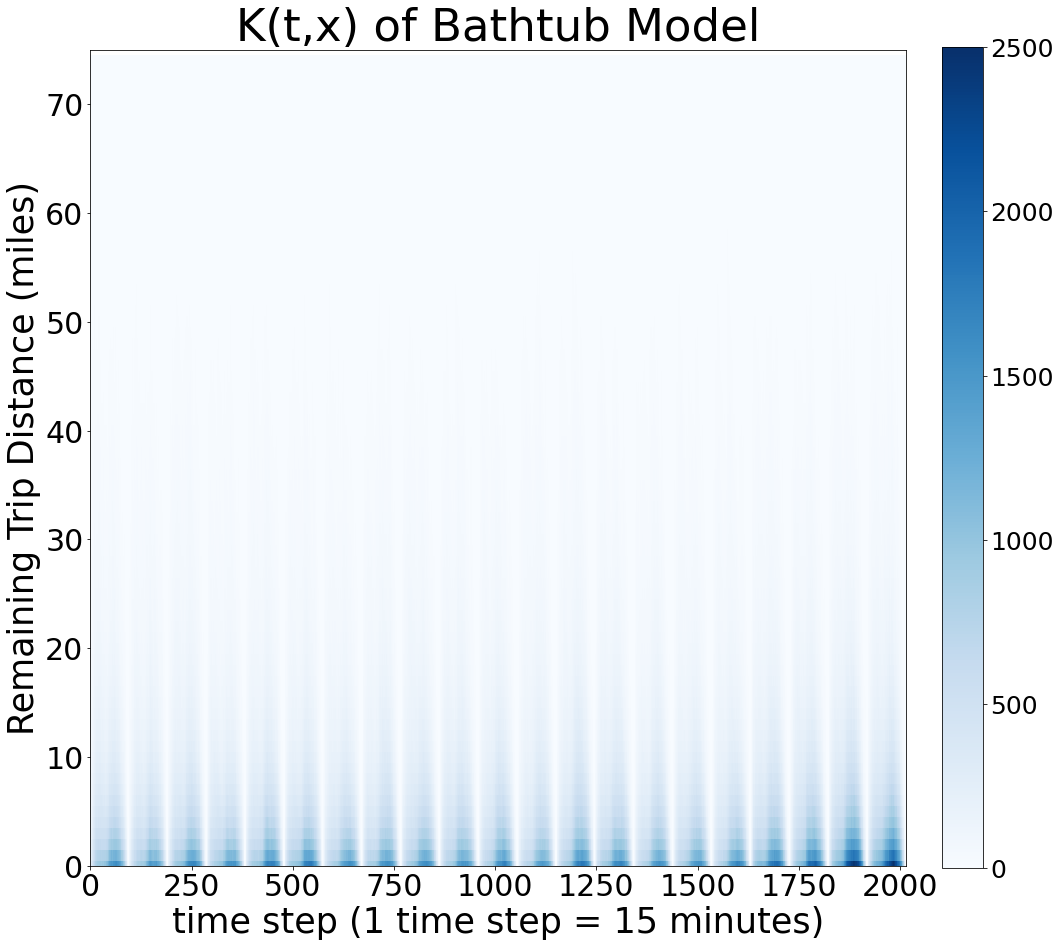

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0061375279754670772 0.01036839603230094 0.0019066599186332136 0.7833191317355205
0.0060826430799296389 0.010241847610482156 0.0019234385493771219 0.7780078758653527
0.00606724026235109 0.010221161725509765 0.0019133187991924152 0.7769864259537637
0.0060221988586173433 0.010203301528111679 0.0018410961891230076 0.775714452248032
0.0059392135121278614 0.010194110405514727 0.0016843166187409952 0.7745297259779463
0.005767529385377208 0.010149878508938913 0.0013851802618155033 0.7715720851677543
0.0055574018636826887 0.01001244289598128 0.0011023608313840971 0.7658175959258315
0.0053611837599858827 0.0098361337253157367 0.000886233794656028 0.7596640046141248
0.0052818279537717181 0.0097882484532207 0.00077540745432273578 0.7586154127730834
0.0052413219287964965 0.0097726708014964567 0.00070997305609653565 0.7584664361247694
0.0051543305853560192 0.0097638682202849537 0.00054479295042708425 0.758889394137739
0.0051252152721689911 0.0097194977698274541 0.00053093277451052789 0.75723453317

0.00322275349813687 0.0055342756165127982 0.00091123137976094131 0.5757513849838484
0.0032223925099184058 0.0055364170600694469 0.00090836795976736507 0.5758398780327347
0.00322184720598293 0.0055398592770107757 0.00090383513495508429 0.5759902288373904
0.0032213446046558394 0.0055636279241753628 0.00087906128513631613 0.5772057749002011
0.0032208801371231906 0.0055428356515888908 0.00089892462265749019 0.5761363313963125
0.0032206783814131374 0.0055415831465805013 0.00089977361624577368 0.5760611539502941
0.003220005828580833 0.0055304343786050508 0.00090957727855661534 0.5755201969005762
0.0032194767783538109 0.00552503697314444 0.00091391658356318245 0.57522031917746
0.0032192037770564404 0.0055375302092663817 0.0009008773448464987 0.5758236913594666
0.0032188567273380795 0.0055337428324547045 0.00090397062222145408 0.5756476022987093
0.0032186239766061856 0.00553062688825156 0.00090662106496081118 0.5755075034791027
0.00321835978283369 0.00552584152805719 0.00091087803761018965 0.5

0.003180571964105055 0.0054529972879346755 0.00090814664027543464 0.5708699022622382
0.0031802135197398019 0.0054538770553654832 0.00090654998411412069 0.5709047995140432
0.0031794884732724397 0.005457486755684895 0.00090149019085998408 0.5710182652049702
0.0031792248988089717 0.0054470218783592905 0.00091142791925865317 0.5704751095293447
0.0031790743470397941 0.005445338913062067 0.00091280978101752116 0.570397406426776
0.0031788349508470332 0.0054455105624825985 0.00091215933921146811 0.5704212752654461
0.003178643657836747 0.0054525280087493414 0.0009047593069241521 0.5707912029849235
0.0031785516468135241 0.00544742164602096 0.0009096816476060883 0.570541354318607
0.003178453891260999 0.0054458926557638832 0.000911015126758115 0.5704479965761793
0.0031783648267349716 0.0054441675388534616 0.000912562114616482 0.5703456613424458
0.0031782697110501832 0.0054451461157065777 0.00091139330639378885 0.5703895727418459
0.0031781824240344 0.0054457321851301647 0.0009106326629386355 0.5704

0.0031732481507734498 0.0054379775903741533 0.000908518711172746 0.5700059759133992
0.0031731810570938762 0.0054354410506853917 0.0009109210635023609 0.5698750477133148
0.0031731668495308231 0.005434155717304847 0.00091217798175679881 0.569798802441803
0.0031731275342910463 0.0054349103675530291 0.00091134470102906381 0.5698382465376699
0.003173086558399828 0.0054353494197482422 0.00091082369705141383 0.5698695867619343
0.0031730505509143326 0.0054392400218459 0.00090686107998276522 0.5700688906750049
0.0031730198757335768 0.0054369274157438858 0.0009091123357232682 0.5699419836522759
0.0031729735312778467 0.0054345765210844733 0.00091137054147121985 0.5698275981565785
0.0031729450847453617 0.0054354346255114979 0.00091045554397922572 0.5698626555073462
0.0031729007103380186 0.00543636267521511 0.0009094387454609273 0.5699270982743957
0.0031728834938789183 0.0054353240749423336 0.00091044291281550311 0.5698696391967815
0.0031728430762043881 0.005436866065523775 0.00090882008688500133 0

0.0031704788136386617 0.0054377233862363226 0.00090323424104100057 0.5699163173710662
0.0031704770040021741 0.0054379763669333558 0.000902977641070992 0.5699280820004708
0.0031704760921140284 0.0054375451170634963 0.00090340706716456076 0.5699090194064627
0.0031704759308249729 0.005437628444210303 0.0009033234174396429 0.5699141165813665
0.0031704758262025741 0.0054376033780750071 0.00090334827433014139 0.5699131751076224
0.0031704753533146374 0.0054375671679122734 0.00090338353871700135 0.5699123556900915
0.003170474424466442 0.0054374851052705073 0.00090346374366237633 0.5699093386845288
0.0031704721575536018 0.00543740130692282 0.00090354300818438333 0.5699068040972218
0.00317046740746093 0.0054373305924819712 0.00090360422243988955 0.5699050062007508
0.0031704576018156713 0.0054373829934285019 0.00090353221020284034 0.5699087891118064
0.0031704366929051222 0.0054377055832486041 0.00090316780256163994 0.5699243982605345
0.0031703875396673891 0.0054387211315921188 0.00090205394774265

0.003168687751840375 0.0054283866013867931 0.00090898890229395689 0.5694381250102246
0.0031686521229919028 0.0054301077299935517 0.00090719651599025387 0.5695293835763108
0.0031686391434427238 0.0054335059785382321 0.00090377230834721533 0.5697175048355062
0.0031686268114449849 0.005432594671617645 0.0009046589512723245 0.5696638872504696
0.0031686222930566747 0.0054306989214024911 0.00090654566471085854 0.5695613240160451
0.0031686165077783966 0.005431243174743707 0.00090598984081308653 0.5695930108641569
0.0031686123165802402 0.00543169800586807 0.00090552662729241021 0.5696191022723013
0.0031686074918634913 0.0054312500337847756 0.00090596494994220735 0.5695985496413604
0.0031686011141931207 0.0054306226467249257 0.00090657958166131571 0.5695658747960569
0.0031685899358972411 0.0054297684244021946 0.00090741144739228761 0.5695219631708102
0.0031685668706975521 0.0054289528236774812 0.00090818091771762322 0.5694748527814512
0.0031685457326574408 0.0054302242720315622 0.00090686719328

0.0031672459493341416 0.0054284098049040431 0.00090608209376423976 0.5694462934004045
0.0031672195497236305 0.0054269224133111004 0.00090751668613616094 0.5693691460540805
0.0031671934570526492 0.0054257591877197378 0.00090862772638556093 0.5693070501939849
0.0031671705144468605 0.0054284805132817663 0.00090586051561195469 0.5694549750766867
0.0031671654769101008 0.0054260195326072541 0.0009083114212129472 0.5693124642245924
0.0031671467949479924 0.0054246540872378074 0.00090963950265817719 0.5692436940709982
0.0031671261176906751 0.0054278710394315343 0.00090638119594981621 0.5694196784977574
0.003167118840159037 0.0054285220481827155 0.00090571563213535889 0.5694487984366947
0.0031671085230634416 0.0054283025587170824 0.00090591448740980031 0.5694314632736879
0.0031670954277959939 0.0054283330341679649 0.00090585782142402313 0.5694327576624414
0.0031670830057132751 0.0054291187332682943 0.00090504727815825627 0.5694746343121059
0.0031670669327975892 0.0054298590383376989 0.0009042748

0.0031634115407000955 0.005421331574937259 0.00090549150646293173 0.5690491208697974
0.003163387334307603 0.0054216949766708366 0.00090507969194436957 0.5690688831754301
0.0031633534436965255 0.0054218744967346726 0.0009048323906583782 0.5690797823352793
0.003163324075763683 0.0054211156070978258 0.0009055325444295402 0.5690416633803606
0.0031632493287404966 0.0054185635397598483 0.000907935117721145 0.5689146092026055
0.0031631703750566423 0.0054198882814885767 0.0009064524686247077 0.5689839147935103
0.0031631417918427532 0.0054187017864321223 0.00090758179725338426 0.5689224707003702
0.0031631024079909272 0.0054179574364158524 0.000908247379566002 0.5688754385512371
0.0031630721175667348 0.0054207679479674553 0.00090537628716601411 0.5690196896675582
0.003163057065194274 0.00542008400985544 0.00090603012053310807 0.5689805867600918
0.0031630517323436003 0.005420887402063309 0.00090521606262389167 0.5690220544559808
0.0031630484992709656 0.0054204722267026106 0.00090562477183932038 0

0.0031604984089042241 0.0054202565616473007 0.00090074025616114787 0.5689471713941348
0.0031604493834533928 0.0054200824249456244 0.00090081634196116113 0.5689242698176408
0.0031603678627720529 0.00541751860097393 0.00090321712457017546 0.5687855145773413
0.0031602362964418445 0.0054173090649414285 0.00090316352794226013 0.5687583192136503
0.00316015720865125 0.00541971230809233 0.000900602109210171 0.5688641598181471
0.0031599895056425948 0.0054236474082680923 0.00089633160301709708 0.5690741860004006
0.0031599109941114782 0.0054221675413405482 0.00089765444688240815 0.5689893521701288
0.0031598406839014365 0.0054216525342396637 0.00089802883356320906 0.5689645455145458
0.0031597679118391237 0.0054206334879501076 0.00089890233572813955 0.5689034492807755
0.0031597403064333256 0.0054192815240486827 0.00090019908881796879 0.5688376933935145
0.003159723926402245 0.0054184788368036741 0.00090096901600081585 0.5687949319672104
0.0031597130631435652 0.0054190125141441673 0.00090041361214296

0.0031556609936956742 0.0054121975531227938 0.00089912443426855477 0.5684547232985102
0.0031556346918143073 0.0054124023451740961 0.00089886703845451846 0.5684699006943259
0.00315562585161968 0.00541239907760125 0.00089885262563811055 0.5684647829326689
0.0031556122996262703 0.0054121545907236312 0.00089907000852890975 0.5684467196649624
0.0031555858024249405 0.0054112385435542022 0.0008999330612956785 0.568392684235327
0.0031555325303723675 0.0054108681956733014 0.00090019686507143367 0.5683583916057307
0.0031554830981610814 0.0054109994134993351 0.0008999667828228277 0.5683671571190759
0.0031554407923335189 0.00541493405077237 0.00089594753389466754 0.5685524625710455
0.0031553810693898269 0.0054155637183690075 0.00089519842041064666 0.5686089114507831
0.0031553651236363943 0.0054125309262646071 0.00089819932100818176 0.5684414087810655
0.0031553169168569268 0.0054136521008645031 0.00089698173284935079 0.5685125256111229
0.0031552723884382462 0.0054157278993565315 0.00089481687751996

0.0031476765429527534 0.0054070795014642689 0.00088827358444123746 0.5679349749132806
0.0031475743878149227 0.0054116113022450851 0.00088353747338476 0.568164724068334
0.0031475051483561651 0.0054103872546147451 0.00088462304209758471 0.5681001532144992
0.0031474603141101506 0.0054083003523200564 0.00088662027590024489 0.5679880269935151
0.0031473778022335511 0.0054091864843713059 0.000885569120095796 0.5680624187251886
0.0031473257945528596 0.0054087637624672807 0.00088588782663843839 0.5680234637037824
0.0031473132119793122 0.0054078201859585426 0.00088680623800008206 0.5679761276774739
0.0031472934543043825 0.0054092748396300325 0.00088531206897873285 0.5680507439977287
0.0031472266186725892 0.00540665195544243 0.000887801281902748 0.5679146427206127
0.0031471050516727549 0.0054032224126019457 0.000890987690743564 0.5677382436222834
0.0031470138120734 0.0054042328185491921 0.00088979480559760768 0.5677734644799475
0.003146945720013138 0.005407944901150828 0.00088594653887544782 0.56

0.003141359986763782 0.0053844019543200158 0.00089831801920754848 0.5668224038095051
0.0031413551657891578 0.0053839000934173282 0.00089881023816098756 0.5667922775609329
0.003141350541009137 0.0053841546059069812 0.00089854647611129325 0.5668077275473502
0.0031413439009877571 0.00538435368506106 0.000898334116914454 0.5668188281825177
0.0031413402631844931 0.0053845175943439119 0.00089816293202507461 0.5668254633547796
0.0031413366101500535 0.0053845075048533459 0.000898165715446761 0.5668230931341561
0.0031413304619865349 0.0053844581349778518 0.0008982027889952183 0.56681912693289
0.0031413210428335924 0.0053844015798098195 0.00089824050585736556 0.5668151087069111
0.0031413017068307003 0.0053843289494725916 0.00089827446418880871 0.5668108430157094
0.0031412567931541316 0.0053827311877549886 0.00089978239855327492 0.5667213243789105
0.0031411730434359143 0.0053821293640701562 0.00090021672280167215 0.5666886297797533
0.0031409822241981146 0.0053820202834353407 0.000899944164960888 

0.0031365278610914981 0.0053661944778638712 0.000906861244319125 0.5658024610782849
0.0031364999288907417 0.0053655617343417927 0.00090743812343969054 0.5657608545741583
0.0031364617941529241 0.005364417119568283 0.00090850646873756515 0.5657149829123475
0.0031364084096737977 0.0053638237843793273 0.0009089930349682686 0.565697466224001
0.003136358282467458 0.0053644253056867666 0.00090829125924814919 0.5657269703914712
0.0031362968370822965 0.0053630712004926724 0.00090952247367192033 0.5656673121183758
0.0031362275691012606 0.0053639561588233187 0.0009084989793792024 0.5657002666845787
0.0031361723640988492 0.0053673009774431006 0.00090504375075459772 0.5658690889539062
0.0031360765446710247 0.0053610187475517622 0.0009111343417902869 0.5655342590251482
0.0031360592925151567 0.0053687942758281178 0.0009033243092021958 0.5659184559686381
0.0031359692626071788 0.0053631146777733578 0.0009088238474410002 0.5656177347667843
0.0031359390881326309 0.0053627098622658778 0.000909168313999383

0.0031298877586651017 0.005365760060520139 0.00089401545681006456 0.5657753069600987
0.0031298233101795655 0.0053654889845186375 0.00089415763584049335 0.5657617674640484
0.0031297358540712224 0.0053634664212509776 0.00089600528689146714 0.5656401646242486
0.0031296816071427411 0.0053656756647540108 0.00089368754953147089 0.565766185440616
0.0031296623423513908 0.0053653770478034489 0.00089394763689933261 0.5657492799839725
0.0031296375964378065 0.0053650584924024459 0.00089421670047316686 0.5657225315708738
0.0031296116215684491 0.0053640354161055654 0.000895187827031333 0.5656764868717092
0.0031295943770800619 0.005365751671926924 0.00089343708223320014 0.5657684061667421
0.0031295884924860524 0.0053655956717678487 0.000893581313204256 0.5657545791339965
0.0031295791055867828 0.005365286033896923 0.00089387217727664268 0.565736436282166
0.0031295737081866075 0.0053656505349791474 0.00089349688139406811 0.5657559359639193
0.0031295516368436303 0.005366158429908968 0.000892944843778292

0.0031196341268162247 0.0053303094938680576 0.00090895875976439145 0.5637289633331627
0.0031193195047382744 0.0053291092571811109 0.00090952975229543771 0.5636556829470357
0.0031189287366810625 0.0053265182885822568 0.00091133918477986843 0.5635339927821974
0.0031187189955327113 0.0053297917811310144 0.00090764620993440809 0.563731217452999
0.0031185823698082552 0.0053299479480388009 0.00090721679157770917 0.5637273275983803
0.0031182902130241713 0.0053282356136775365 0.00090834481237080588 0.5635982504674598
0.0031180249166411966 0.00532925952220705 0.00090679031107534244 0.5636387985579262
0.0031176427178161727 0.005326689099105511 0.00090859633652683452 0.5634928172558401
0.0031173584114131433 0.0053313251374974054 0.00090339168532888145 0.5637920252081459
0.0031171135750905333 0.005344439125926641 0.0008897880242544257 0.5644361798909993
0.00311686726314118 0.0053345989309333628 0.00089913559534899722 0.5639119151116266
0.0031167393599836491 0.0053359549520480111 0.0008975237679192

0.0030786720788784712 0.0053081768298578955 0.00084916732789904706 0.5625550948090643
0.0030783730687253736 0.005318248249447809 0.00083849788800293822 0.5630888982016887
0.0030779804569551722 0.0053113659743573823 0.00084459493955296174 0.5627551846524864
0.0030776590573047893 0.0052994122627040147 0.000855905851905564 0.5621407643580438
0.0030775442545883914 0.0053023298927887125 0.00085275861638807059 0.5622962702297345
0.0030773292125585738 0.0052965234090776511 0.00085813501603949612 0.5619767063118795
0.0030772599473765172 0.0052983094592968993 0.00085621043545613484 0.5620572819552414
0.0030771581267630523 0.0052987428220210818 0.00085557343150502257 0.5620720185364739
0.0030769808088102111 0.0053000625682634358 0.000853899049356986 0.562134229306442
0.0030768690193043458 0.0053000931259093286 0.00085364491269936278 0.5621232983511498
0.003076708008617029 0.0053022724943124619 0.00085114352292159649 0.5622475863469965
0.0030765445422891186 0.0053007385131249793 0.000852350571453

0.00306539679359137 0.0052840104418842146 0.00084678314529852553 0.5612297063713767
0.0030653891404461928 0.0052854621088910094 0.000845316172001376 0.5612946106883061
0.0030653432663469487 0.0052846591491250618 0.00084602738356883518 0.5612608512755896
0.003065319481843012 0.0052843038063938837 0.0008463351572921405 0.5612423766930564
0.0030652625668561783 0.005283869857821707 0.00084665527589064982 0.5612222423826818
0.0030651897082893411 0.0052843998250624155 0.00084597959151626648 0.5612135807215054
0.003065113271877474 0.00528166245835469 0.00084856408540025826 0.561091792884751
0.003065032601193451 0.0052858853421374604 0.00084417986024944147 0.561308718700937
0.0030649700359748804 0.00528235151633778 0.00084758855561198028 0.5611057913560126
0.0030649464786583645 0.0052807439501777612 0.00084914900713896758 0.561019311761694
0.0030649329195136447 0.005282652026536507 0.00084721381249078253 0.5611362816591645
0.0030649104217809059 0.0052821814112077011 0.0008476394323541107 0.561

0.0030621923787681731 0.0052761743807419638 0.00084821037679438244 0.5607347381221977
0.0030621709911305244 0.0052760656422491383 0.00084827634001191036 0.5607122546290778
0.0030621541908879392 0.0052749760263678495 0.00084933235540802848 0.5606596726447567
0.0030621428052893815 0.0052731591590825314 0.00085112645149623212 0.560564413609087
0.0030621322862083395 0.0052745132400719092 0.00084975133234476959 0.5606375387234829
0.0030621184562114817 0.0052736358348615059 0.00085060107756145778 0.5605905474318499
0.0030620971052583183 0.0052725453591261733 0.00085164885139046344 0.5605287213203395
0.0030620840282843034 0.0052718408223520769 0.00085232723421652947 0.5604911795223626
0.0030620588637988704 0.0052727331402638612 0.00085138458733387951 0.560536282922393
0.00306203517135286 0.00527220045120201 0.00085186989150371059 0.5605053915735827
0.0030620092036989814 0.0052709846703456577 0.00085303373705230537 0.560446408509677
0.0030620004085840135 0.0052723467972756169 0.000851654019892

0.003060144351948586 0.00526840673796068 0.00085188196593649222 0.5602632908506218
0.0030601209846262073 0.0052660399474984756 0.00085420202175393945 0.5601406749412382
0.0030600977925629787 0.0052669229784194065 0.00085327260670655075 0.5601895833716471
0.0030600835237476133 0.005266797758934804 0.00085336928856042282 0.5601801194440345
0.0030600701355329432 0.0052602933587339333 0.0008598469123319533 0.5598436070842495
0.003060021643485998 0.0052656449677093388 0.00085439831926265692 0.5601196993101631
0.0030600052760411407 0.00526574628103016 0.00085426427105212148 0.5601326986071943
0.0030599824996615991 0.0052654827972433349 0.00085448220207986331 0.5601219722377755
0.0030599727981628607 0.0052643887630163966 0.0008555568333093248 0.5600608821661354
0.0030599602398304212 0.0052624940486297993 0.000857426431031043 0.5599660089964581
0.00305995463166881 0.0052649240121445985 0.0008549852511930213 0.5600884797659459
0.0030599459738628763 0.0052648075433987728 0.0008550844043269802 0.

0.0030444458301063454 0.0052078483252406028 0.00088104333497208758 0.5573023249607899
0.0030443522550148931 0.005212534806831255 0.00087616970319853086 0.5575678939987586
0.0030441703183923079 0.00520735806671216 0.00088098257007245635 0.5572907874276257
0.0030440438445519186 0.00520672584205978 0.00088136184704405674 0.5572568663845836
0.003043894859314156 0.00520682053985691 0.00088096917877140187 0.557299398877645
0.0030435771102676726 0.0052086503212266672 0.000878503899308678 0.5573935850333269
0.0030434630790098817 0.0052253036690012846 0.00086162248901847831 0.5582999635635346
0.0030431686179606589 0.0052143286221980585 0.000872008613723259 0.5577080394952849
0.0030429287611631181 0.0052108518129444616 0.00087500570938177445 0.557532234373958
0.0030426493270152392 0.0052078945745109174 0.00087740407951956143 0.5573926806994762
0.00304250114997 0.00521002121628762 0.00087498108365237988 0.5575090529108779
0.0030423496645668219 0.0052044049699789992 0.00088029435915464461 0.557210

0.0030246507773625795 0.00514849908565869 0.00090080246906646864 0.554147175572384
0.0030245531342962457 0.0051514327707685393 0.0008976734978239524 0.5542988882868037
0.0030245065302862387 0.0051517880664689163 0.00089722499410356136 0.554324656244856
0.0030244504776652608 0.0051548527113469342 0.00089404824398358772 0.5544875161726646
0.0030244189539076834 0.0051563872153777626 0.00089245069243760393 0.5545753995512305
0.0030243923764130759 0.0051549818292472059 0.00089380292357894625 0.5545054226068031
0.0030243531801743559 0.0051580997516983045 0.00089060660865040726 0.5546673936808739
0.0030243037747276526 0.0051564579525185308 0.00089214959693677427 0.5545837581532042
0.0030242395696073584 0.0051533234755874371 0.00089515566362727988 0.5544257204211416
0.0030242141182266688 0.0051519265428263327 0.00089650169362700529 0.5543554698097216
0.0030241924923959307 0.0051516893160713055 0.00089669566872055569 0.5543449275289682
0.0030241678717471258 0.0051511233330870923 0.0008972124104

0.0030195423977223525 0.0051437473868844626 0.00089533740856024223 0.553896639513171
0.0030195234765428096 0.0051401662753738087 0.00089888067771181051 0.5537053332022456
0.0030194880886970322 0.00514255501277927 0.00089642116461479467 0.553835526872184
0.00301943172019406 0.0051416703390134381 0.00089719310137468264 0.5537864547929247
0.0030193459447572365 0.0051409011327076138 0.000897790756806859 0.553747893329022
0.00301929831519804 0.0051380743727659295 0.000900522257630151 0.5535928708326481
0.0030192644349760081 0.0051382557119972619 0.00090027315795475436 0.5536002939393632
0.0030192336972098806 0.0051385113010857242 0.00089995609333403694 0.553607817070561
0.0030192161048297919 0.0051409044702387541 0.00089752773942083 0.5537336560845583
0.0030191981959007807 0.0051380201946920048 0.00090037619710955658 0.5535827318410844
0.00301918402117467 0.0051385785427439873 0.00089978949960535244 0.5536134511282985
0.0030191619577883155 0.0051383597142822266 0.00089996420129440416 0.5536

0.0030151137362656819 0.0051375939425796 0.000892633529951764 0.5535792355101532
0.0030150028949726335 0.0051351719767633412 0.000894833813181926 0.5534603662255321
0.003014843790318902 0.0051266586840867249 0.00090302889655107877 0.5529982531615772
0.003014750026037035 0.0051318091166206283 0.00089769093545344174 0.5532830870609989
0.0030146864965953715 0.0051266058878959939 0.00090276710529474933 0.5530172016585362
0.0030146050986233335 0.0051273367815460888 0.00090187341570057789 0.5530113476952638
0.0030145588963276745 0.0051265396141970277 0.00090257817845832149 0.5529805547414853
0.0030145066026950724 0.0051280055280762422 0.00090100767731390234 0.5530771623033098
0.0030144503917836356 0.0051274815614531935 0.00090141922211407766 0.5530570563859262
0.0030143995142856727 0.0051287689446914489 0.00090003008387989664 0.5531341866095184
0.003014367934843503 0.0051263172250809843 0.00090241864460602133 0.5529999087269681
0.0030143466797432844 0.0051325537804237931 0.000896139579062775

0.00301213681672202 0.0051259682515831691 0.00089830538186087166 0.5530592617191378
0.0030121234054117248 0.0051308591545685374 0.00089338765625491254 0.5533067691227532
0.0030121019941648647 0.0051268044895614422 0.00089739949876828677 0.5530800927048787
0.0030120805357062882 0.0051261016597358823 0.00089805941167669392 0.5530414177993541
0.0030120503252285919 0.0051264284465046559 0.00089767220395252834 0.5530575864414224
0.0030120176619676561 0.0051247994178870975 0.000899235906048215 0.5529687014296394
0.0030119674361074071 0.0051224181696406567 0.00090151670257415748 0.552815520997859
0.003011922639752254 0.0051245830482924285 0.00089926223121207971 0.552934173198563
0.0030118854906102306 0.0051254411128590863 0.000898329868361375 0.552978583218828
0.003011882542622882 0.0051208764941897246 0.00090288859105603942 0.5527395090190808
0.0030118491111400425 0.0051234516109067915 0.00090024661137329373 0.5528708477353772
0.003011844513246023 0.0051237426143257879 0.00089994641216625815

0.0030061723714923903 0.00512676559710222 0.00088557914588256043 0.5531207383274284
0.003006036588512318 0.0051232647236832685 0.00088880845334136753 0.5529292544586869
0.0030058961948499626 0.0051190657455645614 0.00089272664413536369 0.5526925528650016
0.0030057729567638954 0.0051186730325513512 0.00089287288097643987 0.5526731648775097
0.00300545924438495 0.0051187247708604318 0.00089219371790946842 0.5526828097804888
0.0030052886350768653 0.0051193835893506437 0.00089119368080308673 0.552705416287361
0.0030051252725379614 0.0051149497354371475 0.000895300809638775 0.5524791364703477
0.0030049272934216833 0.0051253771169391523 0.00088447746990421455 0.5530267047209068
0.0030047438918150088 0.0051206813490243209 0.00088880643460569693 0.5527560215007152
0.0030045705070013014 0.00511806637957606 0.00089107463442654315 0.5526200658953768
0.0030044010585358011 0.005120575913415827 0.00088822620365577507 0.5527291831749219
0.0030042132023114705 0.0051192847531848617 0.0008891416514380795

0.0029994271775705774 0.0051115949385483871 0.00088725941659276771 0.5521359935095983
0.0029994162667577686 0.0051102060739729215 0.00088862645954261587 0.5520638213443502
0.0029994127176871414 0.0051098904575249014 0.00088893497784938141 0.5520481465235358
0.0029994059542629188 0.0051101314385794613 0.00088868046994637585 0.5520632967371173
0.0029994003949740905 0.0051100560366666584 0.00088874475328152268 0.5520578272821655
0.0029993919246790214 0.0051105342824323751 0.000888249566925668 0.5520792053898596
0.0029993814937734589 0.0051105732415569587 0.00088818974598995953 0.5520763567229872
0.0029993693240343419 0.0051112190132042608 0.00088751963486442343 0.5520979506376408
0.0029993491979097633 0.0051110565607048221 0.00088764183511470438 0.5520891345254451
0.0029993165457297632 0.0051102210328418688 0.0008884120586176577 0.5520428535953763
0.0029992819729772503 0.00511248745303038 0.00088607649292412054 0.5521496957107359
0.0029992355966072691 0.0051086452144552073 0.0008898259787

0.0029959478260627869 0.005097594478553443 0.00089430117357213075 0.5515976057700336
0.002995940316955558 0.0050983062275688808 0.00089357440634223488 0.5516324901339822
0.00299593346545421 0.0050973628086372789 0.00089450412227114065 0.5515763164821434
0.0029959281429916777 0.0050975415615854445 0.00089431472439791047 0.5515812522451636
0.0029959231247076775 0.0050974008430838434 0.00089444540633151141 0.5515727596453117
0.0029959138730347975 0.0050973874508995322 0.00089444029517006258 0.5515732089795896
0.0029959008103588084 0.0050979081228915259 0.00089389349782609067 0.5515962913103651
0.002995879533819044 0.0050986694149523538 0.00089308965268573436 0.55163101158768
0.0029958460655267615 0.0050986017539544964 0.00089309037709902662 0.5516258297839124
0.0029958038131387269 0.00509799329056732 0.00089361433571013432 0.5515793331841569
0.0029957881971618494 0.0051003689073119748 0.00089120748701172433 0.5517013295997457
0.0029957637956183323 0.0050974577910196123 0.00089406980021705

0.0029932250628108307 0.005095825493892276 0.00089062463172938518 0.5514726566341568
0.0029931958027698468 0.0050958464173519518 0.00089054518818774194 0.5514691284967681
0.0029931521872636787 0.0050935410969247278 0.00089276327760262966 0.5513523366549951
0.0029931072652902087 0.005095276916185003 0.00089093761439541471 0.5514438320182028
0.0029930750358536928 0.0050905800142026052 0.00089557005750478006 0.5511860832697874
0.0029930616372440583 0.0050935238526202261 0.00089259942186789034 0.551339647312121
0.00299301286287489 0.0050920490446607512 0.00089397668108902859 0.5512684375710317
0.0029929862902772072 0.0050907677279105794 0.00089520485264383523 0.5511953500593169
0.0029929666361345891 0.005090728798957919 0.00089520447331125946 0.5511906285079279
0.0029929446190695443 0.0050898171518568994 0.00089607208628218889 0.5511348321240882
0.0029929326072861548 0.005091249166773189 0.00089461604779912088 0.5512087711417035
0.0029929184300284931 0.0050915744618191322 0.000894262398237

0.0029895659678056533 0.005091481847833544 0.00088765008777776252 0.5512297323008529
0.0029895288981098317 0.005089844897309276 0.00088921289891038754 0.5511245622247944
0.0029894709652073179 0.0050910861610984756 0.00088785576931616047 0.5511862937921066
0.0029894146607216095 0.0050913867691971607 0.000887442552246058 0.5512006388002594
0.0029893178047952322 0.005095966086704924 0.0008826695228855403 0.5514513900084386
0.0029892398378897995 0.0050941514753816038 0.0008843282003979957 0.5513547804849925
0.002989183665314356 0.0050945333896546272 0.0008838339409740851 0.5513783679763742
0.0029890840760754787 0.0050914782586434747 0.00088668989350748314 0.5512317902202784
0.0029890222292205991 0.0050981563658580266 0.00087988809258317149 0.5516280514379045
0.0029889439810740128 0.0050908367773304939 0.00088705118481753186 0.5512136112363982
0.0029889009561901532 0.0050903021206082045 0.00088749979177210191 0.5511922752678641
0.0029888473598358649 0.005090493657838307 0.000887201061833422

0.0029867290378499211 0.0050826628456711242 0.00089079523002871819 0.5507898232368724
0.0029866990586761015 0.00508678181652731 0.00088661630082489343 0.5510253114427962
0.00298665169580117 0.0050805810544458279 0.00089272233715651211 0.5506740726411714
0.002986626766213623 0.0050843035344713275 0.00088894999795591874 0.5508798539696441
0.0029866068013632619 0.0050843444838239368 0.00088886911890258735 0.5508837260137318
0.002986590664231261 0.0050840716101780929 0.00088910971828442945 0.5508689190391668
0.0029865833132094559 0.0050833785844856035 0.00088978804193330814 0.5508340913410519
0.0029865757901671162 0.0050844404514957158 0.00088871112883851671 0.5508984209427793
0.0029865649409054097 0.0050834428881811932 0.00088968699362962594 0.5508433909363621
0.0029865508179815468 0.005083402078513587 0.00088969955744950635 0.5508357370148368
0.0029865311671410251 0.0050832088462213895 0.00088985348806066113 0.5508219645190636
0.0029865194329214253 0.0050857661793768062 0.000887272686466

0.0029847595420451397 0.00507951931762866 0.00088999976646161991 0.5507107458806418
0.0029847445675383094 0.005078078444559965 0.00089141069051665355 0.5506261501204788
0.00298472519995355 0.0050799396195916266 0.00088951078031547341 0.5507340305342814
0.0029847101348629977 0.0050807568279014129 0.00088866344182458282 0.5507848279777269
0.0029846882915698612 0.0050787276783641538 0.0008906489047755691 0.5506819865381177
0.002984667625679626 0.0050800991651565666 0.00088923608620268579 0.5507572847441946
0.0029846455943941179 0.0050778272704836728 0.0008914639183045626 0.5506222845731862
0.0029846320574903528 0.005077336131218275 0.000891927983762431 0.5505962446739038
0.0029846105463872227 0.005076695780936457 0.00089252531183798829 0.5505599525412794
0.0029845896471220562 0.0050791818210703145 0.00088999747317379757 0.5506938440438799
0.0029845755394252741 0.0050740034504912681 0.00089514762835928051 0.5504049070050505
0.0029845355963377066 0.0050783904953346729 0.00089068069734074041

0.002981875289794743 0.0050763417488846026 0.000887408830704883 0.5505059056257612
0.0029818625689748647 0.0050775201989605619 0.00088620493898916748 0.5505680051096346
0.0029818413584297991 0.0050778704040495507 0.00088581231281004776 0.55058479448666
0.002981809255577872 0.0050769627747986436 0.00088665573635710049 0.5505391933995609
0.00298179263621055 0.0050788021531489088 0.00088478311927219075 0.5506390611704403
0.0029817674048188232 0.0050771792097394118 0.00088635559989823484 0.5505545599053248
0.0029817473704302861 0.00507616420909029 0.00088733053177028219 0.5504994648809003
0.002981714094044591 0.0050758604297860034 0.00088756775830317863 0.5504868509656182
0.0029816932764274852 0.0050749070692676628 0.00088847948358730764 0.550433069408318
0.0029816769145209472 0.0050767717296725254 0.00088658209936936887 0.5505356900077213
0.0029816663149741197 0.0050758388016792612 0.00088749382826897776 0.5504831413164665
0.0029816590017021994 0.0050759399537531015 0.00088737804965129683

0.0029800785371192429 0.0050712296211780777 0.00088892745306040784 0.5502368595524458
0.0029800489156037043 0.0050691819014177172 0.00089091592978969146 0.5501233646553818
0.0029800051720134902 0.0050706110661536555 0.00088939927787332529 0.5501869108881825
0.0029799911516222377 0.0050721759857279454 0.00088780631751653053 0.5502674128264053
0.0029799669471221716 0.0050718549157124752 0.00088807897853186821 0.5502433231074532
0.0029799591963973 0.00507340792314272 0.00088651046965187985 0.5503282776999149
0.0029799488315387385 0.0050705385427529679 0.00088935912032450908 0.5501811792160046
0.0029799400390255614 0.0050713132067849494 0.00088856687126617317 0.5502168852099797
0.002979935332118845 0.005071672482663157 0.000888198181574533 0.5502347699782142
0.0029799310034192179 0.0050714907939893705 0.00088837121284906541 0.550226547178542
0.002979926816216586 0.005071016860993551 0.00088883677143962122 0.550202319067403
0.0029799235096411576 0.005071087292226063 0.00088875972705625258 0

0.0029794177257685532 0.0050670382464717617 0.00089179720506534486 0.5499328548877614
0.0029793895684880043 0.005066031391751373 0.00089274774522463563 0.5498759413190594
0.0029793612092471108 0.0050636653409430179 0.00089505707755120406 0.5497563452988844
0.0029793291127028845 0.005065984073573779 0.00089267415183199 0.5498808273158083
0.0029793051977589496 0.0050664245161326791 0.00089218587938522055 0.549926106418813
0.0029792844331134791 0.0050643733659946526 0.00089419550023230553 0.5498123352196839
0.0029792491340014477 0.00506321603757732 0.00089528223042557539 0.5497484060074298
0.0029792259127268952 0.0050665144290469415 0.00089193739640684884 0.5499189563363985
0.0029791927404942443 0.00506447956194988 0.000893905919038609 0.5498092240465698
0.0029791479011232278 0.0050626188399551927 0.00089567696229126336 0.5497106975338666
0.0029790964920477147 0.0050635607893978985 0.00089463219469753123 0.5497752893256211
0.0029790464665106083 0.0050588642396672094 0.0008992286933540072 

0.0029773936223667285 0.0050614408432915906 0.00089334640144186689 0.549702410288501
0.0029773849012553746 0.005061938492783905 0.000892831309726844 0.5497273353650051
0.0029773779084235532 0.0050628488120497521 0.00089190700479735451 0.5497753043790282
0.0029773743812037774 0.0050627356201292627 0.00089201314227829221 0.5497655415659195
0.0029773688661507572 0.0050640543155075221 0.000890683416793992 0.5498343941631562
0.0029773649477543721 0.0050642030461355006 0.0008905268493732435 0.5498423389524575
0.0029773594142273874 0.00506428514686283 0.00089043368159194428 0.5498466411382738
0.0029773567736766727 0.0050640067391854683 0.00089070680816787746 0.5498345765391119
0.0029773513729916415 0.0050635151017345238 0.00089118764424875937 0.5498073383430717
0.00297734692945996 0.0050637928516538153 0.00089090100726610486 0.5498237661463459
0.0029773419575369912 0.0050632342652725615 0.00089144964980142089 0.549793607582453
0.0029773378404660215 0.0050629674091083416 0.00089170827182370163

0.0029762659815088981 0.0050639050336839 0.00088862692933389673 0.5498634743712074
0.0029762557884798237 0.0050639887647604314 0.00088852281219921618 0.5498635724540305
0.0029762485048220209 0.005064064458313965 0.00088843255133007684 0.5498627536449145
0.0029762418069361357 0.0050643331283185431 0.00088815048555372785 0.5498801245852036
0.0029762353184742268 0.0050645603875717682 0.00088791024937668532 0.5498928894264945
0.0029762301018103413 0.0050662416007504745 0.00088621860287020767 0.5499852771370546
0.0029762260047110694 0.0050654210990442134 0.000887030910377925 0.549942583283165
0.0029762222952671989 0.005065591208860392 0.00088685338167400539 0.5499541774899848
0.0029762175932522418 0.005065320722801147 0.0008871144637033363 0.5499400115084234
0.0029762115773615547 0.0050651390671628289 0.00088728408756028065 0.5499263007964563
0.0029762066455307082 0.0050645726120523869 0.00088784067900903 0.5498971988190584
0.002976203227314064 0.0050638369102404494 0.00088856954438767879 0

0.0029748052845919018 0.0050770085808766316 0.00087260198830717219 0.5505862448519983
0.0029747808137263331 0.0050756256193144906 0.00087393600813817532 0.5505216451645966
0.0029747558712435109 0.0050753860764964622 0.0008741256659905598 0.5505100923598193
0.0029747139959212985 0.0050748404028614288 0.00087458758898116789 0.5504858365052393
0.0029746998898790658 0.0050734410101572437 0.00087595876960088772 0.5504100948851568
0.0029746725316758104 0.0050750789310219386 0.000874266132329682 0.5505012923606842
0.0029746499909543526 0.0050742984597112331 0.00087500152219747236 0.55045655731381
0.0029746301973969888 0.0050739688773711669 0.00087529151742281092 0.5504477771664118
0.0029746117617267332 0.0050755021791297024 0.00087372134432376432 0.5505261388855945
0.0029745981623222708 0.0050719972417201734 0.00087719908292436806 0.5503463382672021
0.0029745707669427005 0.0050740025482009276 0.00087513898568447384 0.5504530556016601
0.002974539659652132 0.0050747463437248288 0.00087433297557

0.0029734682065479063 0.0050741862123089712 0.00087275020078684184 0.5505531721711698
0.0029734597581951645 0.0050741691930149711 0.00087275032337535779 0.550553202100942
0.0029734546198448802 0.0050737062309077537 0.00087320300878200639 0.5505330200838546
0.0029734375667199307 0.0050740436436769237 0.0008728314897629378 0.5505485094060777
0.0029734186829489507 0.0050746725644173138 0.00087216480148058777 0.550583720415008
0.00297339178033389 0.0050749609910836647 0.00087182256958411573 0.5506035865634682
0.0029733722258237726 0.005075422527026161 0.00087132192462138444 0.5506367761043682
0.0029733615168667659 0.0050745708182819262 0.00087215221545160573 0.5505880797858987
0.0029733497397241662 0.0050742675375912072 0.00087243194185712518 0.5505780805096145
0.0029733417577046876 0.0050746270113466276 0.000872056504062748 0.5505976294207283
0.0029733314354750454 0.0050746364878350766 0.00087202638311501446 0.5505984161253795
0.0029733204370964534 0.0050751298143759368 0.0008715110598169

0.0029709609507650712 0.0050620018766182676 0.00087992002491187483 0.5502092496683456
0.0029708908597724823 0.0050622683164726259 0.00087951340307233837 0.5502106480457434
0.0029708613366384584 0.0050649757289895382 0.00087674694428737873 0.5503738712274276
0.0029708223447510789 0.0050633395542349982 0.00087830513526715947 0.5502774817838564
0.002970803400010295 0.0050605059842308061 0.00088110081578978349 0.5501269649087398
0.0029707799317268933 0.005061946602025298 0.00087961326142848878 0.5502138142017096
0.0029707413254301072 0.0050642640372208564 0.00087721861363935811 0.5503448742961896
0.0029707188033191974 0.0050625881259697657 0.00087884948066862894 0.5502618217561904
0.0029706935035941151 0.0050631550987707986 0.00087823190841743138 0.5502889753305766
0.00297066137379746 0.0050647501030176628 0.00087657264457725675 0.5503862762638738
0.0029706381654088414 0.0050639374643229509 0.00087733886649473227 0.5503440242756532
0.0029706112856857062 0.0050605387102578177 0.000880683861

0.002968263331669988 0.005061803380055077 0.00087472328328489911 0.5502167484685061
0.002968212668922862 0.0050546758695396571 0.00088174946830606735 0.549844087940453
0.0029681851679843971 0.0050572679913601154 0.00087910234460867871 0.5499829627836242
0.0029681373838358637 0.0050576877097059623 0.0008785870579657649 0.550006181578851
0.0029681038670296917 0.0050572554276990811 0.00087895230636030194 0.5499851871117281
0.0029680747363110818 0.0050566466303679138 0.00087950284225424974 0.5499548904109575
0.0029680619580613574 0.0050587281972722031 0.000877395718850512 0.5500769987841857
0.0029680407324222755 0.0050579695544161994 0.00087811191042835163 0.5500343708825763
0.0029680082943552896 0.0050567076409812929 0.00087930894772928576 0.5499629645556554
0.00296796564293394 0.0050547343163394147 0.00088119696952846554 0.5498717077286406
0.0029679122805833986 0.0050563051889517428 0.00087951937221505451 0.5499619369080789
0.0029678780160026616 0.0050555116517543193 0.000880244380251004

0.002963422206787325 0.0050451325484033175 0.00088171186517133266 0.5493811846606004
0.0029633617564655138 0.0050457347750158784 0.00088098873791514942 0.5494080831304736
0.002963326345325082 0.0050486648390926014 0.00087798785155756263 0.5495684247166159
0.0029632740214480847 0.0050487765259879611 0.00087777151690820836 0.5495685151050422
0.0029632105177919751 0.0050466901179549353 0.00087973091762901532 0.5494713241151401
0.0029631500464024421 0.0050480501603698043 0.00087824993243507945 0.5495503805100953
0.0029630666414690132 0.0050506318584565774 0.00087550142448144922 0.5496890590066288
0.0029630090717906237 0.005048440559154801 0.00087757758442644684 0.549541463931151
0.0029629252647187959 0.0050510009021384307 0.00087484962729916132 0.54970316240333
0.0029628903905292389 0.0050515389170571034 0.00087424186400137424 0.5497300788444961
0.0029628631238140576 0.005049176813871235 0.00087654943375688025 0.549596612967269
0.0029628493200711419 0.0050498756960593218 0.0008758229440829

0.0029611780730881146 0.005053782101131026 0.00086857404504520313 0.5498641572415649
0.0029611658521643551 0.005052523294003233 0.00086980841032547717 0.5497999164420095
0.0029611571063222404 0.00505249804046624 0.00086981617217824132 0.5497998113669839
0.0029611481739473004 0.0050526741377600326 0.00086962221013456818 0.5498091006608501
0.0029611430803916819 0.0050527452475799765 0.00086954091320338718 0.5498171836386766
0.0029611340425396127 0.0050532669938632485 0.00086900109121597672 0.5498516796832671
0.0029611293123887506 0.00505274116294293 0.00086951746183457112 0.5498235167085634
0.0029611212573905305 0.0050524381204862835 0.000869804394294777 0.5498080712510324
0.0029611088405018479 0.0050523519278157019 0.00086986575318799412 0.5498014554409887
0.0029611067156277335 0.0050522518413487231 0.00086996158990674372 0.5497988841242863
0.0029611004966575045 0.0050528739124459177 0.00086932708086909173 0.5498297819812876
0.0029610925259197993 0.0050535041084807455 0.0008686809433588

0.0029601636438031246 0.0050522906890406441 0.00086803659856560461 0.5497625220389546
0.0029601409998341851 0.0050521861104898067 0.0008680958891785635 0.5497525425409987
0.0029601262928288931 0.0050523259336258709 0.00086792665203191521 0.5497721136583877
0.0029601087131285084 0.0050538661943003776 0.00086635123195663946 0.5498564590290971
0.0029600870695213437 0.005052936755371793 0.00086723738367089484 0.5498039337908793
0.0029600684081340944 0.0050533387226413089 0.00086679809362687969 0.5498313383685596
0.0029600558013120849 0.00505334738881115 0.00086676421381302058 0.5498388407626147
0.00296002508729906 0.0050529213325262714 0.00086712884207184877 0.5498183707838543
0.0029600115248266442 0.0050557887573698251 0.00086423429228346324 0.5499468727021697
0.0029599736038944131 0.00505382897899598 0.00086611822879284581 0.549855254582769
0.0029599607019726785 0.0050530385110461691 0.00086688289289918832 0.5498256663499294
0.0029599135323430574 0.0050548403221738567 0.00086498674251225

0.0029585577442079684 0.0050548088180503966 0.0008623066703655405 0.5498742063329671
0.0029585553749422117 0.0050542820705424246 0.00086282867934199872 0.549845486238277
0.0029585464495182697 0.0050544645025737021 0.00086262839646283711 0.5498538697932271
0.0029585406205542746 0.00505496325571648 0.00086211798539206907 0.5498786525003894
0.0029585348665808267 0.00505491823636981 0.00086215149679184347 0.5498773766358639
0.0029585285347584513 0.0050556268093468635 0.000861430260170039 0.5499139769323528
0.00295852094081864 0.0050551677621726021 0.00086187411946467849 0.549890200076879
0.0029585112676681555 0.0050549581960638778 0.00086206433927243323 0.5498850312985588
0.0029585081927227057 0.00505419046929012 0.00086282591615529129 0.5498458029591234
0.0029584995565888833 0.0050546101799358754 0.00086238893324189084 0.5498664292889914
0.0029584961006278144 0.005054965766906931 0.00086202643434869753 0.549887319258527
0.0029584908680775302 0.0050553030918621912 0.00086167864429286911 0.

0.0029573977921247977 0.0050575912112493628 0.00085720437300023224 0.5499667414360628
0.0029573780429859578 0.00505670169767491 0.00085805438829700514 0.5499122338347938
0.0029573369533211903 0.0050550977537275549 0.000859576152914826 0.5498094752819347
0.0029573160921340827 0.0050542362037633726 0.00086039598050479283 0.5497665246965565
0.0029572903049439507 0.0050544469119116787 0.00086013369797622306 0.549779483636359
0.0029572513080078455 0.00505266489284163 0.00086183772317406139 0.549684415294695
0.0029572160703245547 0.0050531712826116671 0.00086126085803744272 0.5497179504022536
0.0029571832622672951 0.0050542028611664019 0.00086016366336818791 0.5497815578336216
0.00295716328508826 0.0050551496019384618 0.00085917696823805778 0.5498308588217825
0.0029571437036176843 0.0050534632652782466 0.00086082414195712178 0.5497332220501923
0.0029571166729513263 0.00505366452889928 0.000860568817003373 0.5497397900312266
0.002957092276661626 0.0050532766123836184 0.00086090794093963367 0.

0.0029560193271087874 0.0050467635147364862 0.00086527513948108845 0.5493771783969604
0.0029560120406846024 0.0050475230237642943 0.00086450105760491047 0.5494160851326646
0.0029560082163696943 0.0050468171681539806 0.0008651992645854076 0.5493785411524298
0.0029560039272633573 0.0050468301974238043 0.00086517765710290991 0.5493747441200514
0.0029559997921468411 0.0050467195552031741 0.0008652800290905086 0.5493713210392729
0.0029559949455041606 0.0050465296776946965 0.00086546021331362455 0.5493630032594693
0.0029559876108773316 0.0050463065408568189 0.0008656686808978445 0.5493544665316142
0.0029559805745310338 0.0050459447308273094 0.0008660164182347584 0.5493381053722672
0.0029559742721684324 0.0050460443687441675 0.00086590417559269731 0.5493453439084361
0.0029559696507446744 0.0050462039202982187 0.0008657353811911306 0.5493515096635734
0.002955964034277646 0.0050454927537207581 0.00086643531483453413 0.54931274375488
0.0029559592434028272 0.00504663271280974 0.000865285773995914

0.002955353891324352 0.0050440396045485555 0.00086666817810014858 0.5492399284149361
0.0029553509963659835 0.0050440090353391816 0.00086669295739278524 0.5492404942049095
0.0029553470639117215 0.0050437669621755136 0.00086692716564792938 0.5492250045220377
0.0029553411335226485 0.0050441584690518425 0.0008665237979934541 0.5492422713232088
0.0029553344837489458 0.0050438339587062448 0.000866835008791647 0.5492188103985433
0.0029553255500280639 0.0050439367269438607 0.00086671437311226719 0.5492189184449043
0.0029553218260734071 0.00504388706064119 0.0008667565915056241 0.5492146952517605
0.0029553117485881797 0.0050437627625442519 0.00086686073463210775 0.5492146790567753
0.0029553083533857697 0.00504332973196195 0.00086728697480958938 0.5491951719019582
0.002955305421211943 0.0050436776165586443 0.00086693322586524216 0.5492181610344241
0.0029553037871819007 0.0050435281398651458 0.00086707943449865557 0.5492103381224499
0.002955301312521487 0.0050437376783545916 0.000866864946688382 

0.0029543707265228198 0.0050423074950671038 0.000866433957978536 0.5491072793685517
0.0029543646727610623 0.0050425058253714006 0.00086622352015072344 0.5491206339589878
0.00295435561810503 0.0050425805177224279 0.00086613071848763181 0.5491244273449413
0.00295434363057392 0.0050422277113440651 0.00086645954980377454 0.5491095928876351
0.0029543195683343925 0.0050413589846341478 0.00086728015203463716 0.549073037281091
0.0029543088135883986 0.005040050846544312 0.00086856678063248528 0.5490031907499721
0.0029542925409912113 0.0050392418601380657 0.00086934322184435676 0.5489617327046423
0.0029542797487794314 0.0050389845643701728 0.00086957493318868986 0.5489521331554688
0.0029542668618469112 0.0050395664324105818 0.000868967291283241 0.548983295743349
0.0029542489445843014 0.0050401314124137436 0.00086836647675485952 0.5490189218696578
0.0029542353105104233 0.0050404856817946493 0.00086798493922619706 0.5490417771836344
0.0029542228054839589 0.0050402308520665837 0.0008682147589013343

0.0029536673691367603 0.0050387632493602277 0.00086857148891329294 0.5489327388098384
0.0029536504806914527 0.0050387280871247338 0.00086857287425817157 0.5489329334035239
0.0029536216255191461 0.0050393576884564875 0.00086788556258180448 0.5489643266554599
0.0029535620572441242 0.0050411455614275576 0.00086597855306069121 0.5490549949321721
0.0029535524682629466 0.0050414934928073385 0.00086561144371855416 0.5490744443992177
0.0029535175262990197 0.0050385482025635427 0.00086848685003449648 0.5489174773417334
0.0029534374003148639 0.0050358559069731872 0.0008710188936565409 0.5487805827837674
0.0029533031060547852 0.00503688106442331 0.00086972514768625961 0.5488178007517316
0.00295315488508342 0.0050382776872167738 0.00086803208295006666 0.5489036080839915
0.0029530290056091041 0.0050358150140270772 0.00087024299719113112 0.5487803431811835
0.0029529388525241645 0.0050345198858993212 0.00087135781914900754 0.5487106246129553
0.0029528851012443078 0.0050357745193278 0.0008699956831608

0.0029498012065508035 0.0050347002237461705 0.00086490218935543657 0.5487818100967675
0.0029497752376858831 0.0050353189343214626 0.00086423154105030311 0.548817820644499
0.0029497430279625159 0.0050356888580891544 0.00086379719783587726 0.5488382666800784
0.0029497033908418113 0.0050375294201284665 0.00086187736155515619 0.5489346396998228
0.0029496912249378261 0.0050368118543857848 0.00086257059548986771 0.5488934312976883
0.0029496394090171457 0.00503800149922313 0.00086127731881116131 0.5489488481415592
0.0029496188343890689 0.005039749051918274 0.0008594886168598638 0.5490374943957209
0.0029495752897109226 0.0050395460206869216 0.00085960455873492392 0.5490164642170196
0.0029495277388777723 0.0050388042224974736 0.00086025125525807089 0.5489556504016194
0.0029494949197272345 0.0050414661609787881 0.00085752367847568114 0.5490856775925738
0.0029494650274489403 0.0050411646936078134 0.0008577653612900669 0.5490682543745319
0.0029494458684571527 0.0050413498599348244 0.00085754187697

0.0029458794796130639 0.0050339260017322794 0.00085783295749384809 0.5487407326499979
0.0029458595230414863 0.0050330324330420248 0.00085868661304094819 0.5486954298312463
0.002945837088235796 0.0050321086587550266 0.00085956551771656522 0.5486439127111414
0.0029458081260866952 0.0050322557639090873 0.00085936048826430343 0.5486532797418379
0.0029457834439736686 0.0050313100524841687 0.00086025683546316859 0.5485960692575157
0.0029457482698445293 0.0050311216077668858 0.00086037493192217291 0.5485859484059297
0.0029457076480362086 0.005031900569204298 0.00085951472686811921 0.5486103306978419
0.0029456860484969281 0.0050320264434443353 0.00085934565354952143 0.5486203570155871
0.0029456582426292018 0.00502949078847487 0.00086182569678353331 0.5484912728276534
0.0029456260633415406 0.0050326382351055209 0.00085861389157756041 0.5486389830868027
0.0029455609503630286 0.0050314644027582523 0.00085965749796780512 0.5485869663769191
0.0029455448210875669 0.0050225176489824327 0.000868571993

0.0029432401487817371 0.0050282481883218346 0.00085823210924163961 0.5484250991998978
0.0029432114134849987 0.00502277356989785 0.00086364925707214761 0.5481629742935015
0.0029431601637887792 0.0050250745767113055 0.000861245750866253 0.5482799225378929
0.0029430990672902045 0.0050251275516000251 0.00086107058298038415 0.5482734129000073
0.0029430272949476609 0.0050257508091041021 0.0008603037807912192 0.5483159604833238
0.0029429646241339287 0.00502491749224975 0.00086101175601810767 0.5482745680462459
0.0029429353754693677 0.0050250180567009209 0.00086085269423781454 0.5483044334093358
0.002942899814744914 0.0050220106224336874 0.00086378900705614094 0.5481487691199597
0.0029428811101776006 0.0050244970987563965 0.000861265121598805 0.5482735115724509
0.0029428607571726634 0.0050253828985510653 0.00086033861579426106 0.5483209093755738
0.002942839724766202 0.005027249240663197 0.00085843020886920717 0.5484178467828129
0.0029428182046208505 0.0050275740973902859 0.000858062311851415 0

0.0029400194031818376 0.00500688321377561 0.00087315559258806523 0.5469816414315993
0.0029400105622195702 0.00500724354675042 0.00087277757768872046 0.5469985967403149
0.0029400000102913068 0.0050070753688662029 0.000872924651716411 0.5469883332344554
0.0029399882381153822 0.0050063807967194044 0.00087359567951136006 0.5469494094469196
0.0029399757428375554 0.005004855161299223 0.000875096324375888 0.5468663278850209
0.0029399649845733896 0.0050040954616032592 0.00087583450754351972 0.546824028791024
0.0029399512940623384 0.0050032164725656051 0.000876686115559072 0.5467757897552272
0.0029399306636936694 0.0050031612119432519 0.00087670011544408713 0.5467691169205655
0.0029399086570201407 0.0050011609499298025 0.00087865636411047865 0.5466587844859707
0.002939893575553694 0.0050042085862331293 0.00087557856487425882 0.5468125282763132
0.0029398669370015547 0.0050035426987298957 0.00087619117527321371 0.5467801973620766
0.0029398525724395538 0.0050026486853365758 0.00087705645954253171 

0.0029389077314857016 0.0050012438320126912 0.00087657163095871185 0.5466671380863038
0.0029388827992050367 0.0050001956570847484 0.0008775699413253249 0.5466117021177994
0.0029388686042055492 0.0049998000224884247 0.0008779371859226736 0.5465849335193026
0.0029388340838026575 0.0050002210785678241 0.000877447089037491 0.5465922193177082
0.0029388109821240609 0.0050004842258128731 0.00087713773843524844 0.5465969751275429
0.0029387834937080496 0.0050032694881607031 0.00087429749925539582 0.5467405887972806
0.0029387378437742023 0.0050025782660717277 0.000874897421476677 0.5467093989252296
0.0029386671762519053 0.0050020613606518178 0.00087527299185199275 0.546691817670697
0.0029386121345169268 0.0050029348834506561 0.00087428938558319752 0.5467382109165527
0.0029385664664761833 0.0050028228993619127 0.00087431003359045431 0.5467297093370843
0.0029385205626250746 0.005004629392947671 0.0008724117323024779 0.5468104735868836
0.0029384989503651398 0.0050001619365710893 0.00087683596415919

0.0029360183100832311 0.0049984521239885386 0.00087358449617792357 0.5464192210543447
0.0029359912059951777 0.0049976523103346963 0.00087433010165565914 0.5463771838566521
0.002935940664646862 0.0049963079671266194 0.00087557336216710451 0.5463117245500451
0.0029359056327680185 0.0049976309709493872 0.00087418029458664957 0.5463880857854206
0.002935854362943247 0.0049972037410230029 0.00087450498486349112 0.5463781027585438
0.0029358221854448672 0.005001818809008832 0.00086982556188090233 0.5466098980543328
0.0029358020796748396 0.0050018843151860672 0.0008697198441636123 0.5466091545261618
0.002935780648627912 0.0049988610094088637 0.00087270028784696069 0.5464504931489692
0.0029357563977683685 0.005000058827773989 0.00087145396776274777 0.5465136961718988
0.0029357395091950886 0.0049989551486924726 0.00087252386969770431 0.5464459752064919
0.0029357251220347908 0.0050007940061826042 0.00087065623788697773 0.5465507391656632
0.0029357131857252307 0.0050013874112902852 0.00087003896016

0.0029342056176797928 0.0050072760252910234 0.00086113521006856222 0.5468713762522632
0.0029341802737779671 0.0050054046323646838 0.00086295591519125036 0.5467614839525049
0.0029341392711857905 0.0050068350956474885 0.00086144344672409265 0.5468365856083375
0.0029340801687303595 0.00500422135932657 0.00086393897813414927 0.5467008965078926
0.0029340410709933961 0.0050066013235410172 0.00086148081844577543 0.546840458783756
0.002933994023256328 0.005010045826635 0.00085794221987765557 0.5470164623136722
0.0029339612742711931 0.005007161317738121 0.00086076123080426538 0.5468557360434558
0.0029339511792315842 0.005007027197578116 0.00086087516088505234 0.5468256835256691
0.0029338933891382823 0.0050056942041435742 0.00086209257413299035 0.5467690173770984
0.0029338638400138953 0.0050073735590913694 0.00086035412093642106 0.5468548399109364
0.0029338327103053861 0.0050052987903961167 0.00086236663021465579 0.5467331020529076
0.0029338038731782463 0.005008709488483999 0.0008588982578724937

0.0027127865628254347 0.0048722884132260183 0.0005532847124248508 0.5365601768727541
0.0027061977361156815 0.0048588992651966327 0.00055349620703472986 0.5357426871884011
0.0027001810966838335 0.0048659424730243756 0.0005344197203432918 0.5358501841960314
0.00269657252824538 0.0048644147253541267 0.00052873033113663324 0.535674807614366
0.0026950749051362485 0.0048510723478975629 0.00053907746237493424 0.5345109305019563
0.0026893887438009141 0.00487594857548381 0.00050282891211801846 0.5355698992660533
0.0026859834909925659 0.0048832066084442344 0.00048876037354089773 0.5359739241114756
0.0026842902970241221 0.0048975980462382593 0.00047098254780998514 0.5366489759490173
0.0026811613846342234 0.0049138346413981522 0.00044848812787029468 0.5373746788335236
0.0026761316859596372 0.0049116360706144106 0.00044062730130486389 0.5371238082631574
0.0026729785225162732 0.0049011314251026037 0.00044482561992994265 0.5361432771044895
0.0026591168072786025 0.004898571070773244 0.0004196625437839

0.00259481065486799 0.0048675302660599242 0.00032209104367605631 0.5347509128531334
0.0025944239673486094 0.0048642053835426793 0.00032464255115453964 0.5345819460836633
0.0025939225572074918 0.0048675084536079832 0.00032033666080700049 0.5348048887321388
0.0025936506936323402 0.0048601474808983389 0.00032715390636634136 0.5343961881201091
0.0025932433133126721 0.0048634911896469476 0.00032299543697839652 0.5346065103237462
0.0025929243156890425 0.0048604603993944564 0.00032538823198362911 0.5344628410599905
0.0025926948608136738 0.0048587401516934723 0.00032664956993387558 0.5343797081474513
0.0025924233788710569 0.0048502267813694318 0.00033461997637268174 0.5339211257049035
0.0025920505741835903 0.0048492061751975474 0.00033489497316963312 0.533885278089226
0.0025914321248305138 0.0048483111557091176 0.00033455309395191045 0.5338771824212581
0.0025909557170280093 0.0048475606444815 0.00033435078957451804 0.5337873765831341
0.0025906937509130937 0.0048421369952872627 0.00033925050653

0.0025719422105353372 0.00483129262003798 0.00031259180103269414 0.5326979305066821
0.0025718610828232005 0.0048301253043403014 0.00031359686130609965 0.5326273572556491
0.0025717552754655941 0.004828140597457572 0.00031536995347361644 0.5325064430992499
0.0025716582303580704 0.0048288869998417442 0.00031442946087439612 0.5325066742971546
0.0025714452938398148 0.00482723159743403 0.00031565899024559979 0.532423302377547
0.0025711964017493621 0.0048274424225702994 0.00031495038092842448 0.5324307419838508
0.0025708474675069492 0.0048277260213679552 0.00031396891364594273 0.5324489380061128
0.0025705002519754595 0.0048268376107892 0.00031416289316171857 0.5323749445262375
0.0025702452017722596 0.0048289800455058353 0.00031151035803868358 0.5324819066836403
0.0025702393770206645 0.0048328397750730771 0.00030763897896825216 0.5327315868997738
0.0025699367061152896 0.0048288132603538257 0.00031106015187675363 0.5324532088468975
0.0025698736571105733 0.0048269223611250873 0.00031282495309605

0.0025655572625165966 0.0048210550372528149 0.00031005948778037784 0.5319010947079428
0.0025654584093331339 0.0048223740773824511 0.00030854274128381637 0.5319335785279528
0.0025653312884154869 0.0048191769053493212 0.00031148567148165274 0.5317200950304162
0.0025652458852048038 0.0048168924414247445 0.00031359932898486313 0.5315457283230043
0.0025651749028842673 0.0048157924029600049 0.00031455740280852956 0.5314337288567763
0.0025651559932642425 0.0048151281919344936 0.0003151837945939911 0.5314048216616061
0.0025651240889895959 0.0048148810011638954 0.00031536717681529617 0.5314172380405614
0.002565096642692511 0.00481573244571259 0.00031446083967243235 0.5314484889968186
0.0025650807375433705 0.0048177994906926213 0.00031236198439411943 0.5315873069752818
0.0025650620090475252 0.0048160881811888942 0.00031403583690615603 0.531484580729483
0.0025650478369915962 0.0048159936689669757 0.0003141020050162169 0.5314609787477952
0.002565037598019 0.0048165837705609347 0.000313491425477065

0.0025643206617346976 0.0048160167157659112 0.00031262460770348357 0.5313644183728183
0.0025642523607141386 0.0048159618397775536 0.0003125428816507232 0.531392826587117
0.0025641996119759808 0.0048171369518924673 0.00031126227205949448 0.5314864879321592
0.0025641680560946137 0.0048173036496008282 0.000311032462588399 0.5314952988413731
0.0025641465814954423 0.0048185392727417781 0.00030975389024910649 0.5315696572448841
0.0025641426203138504 0.0048181641444074164 0.00031012109622028451 0.5315493336229629
0.0025641400400934372 0.0048181225701252979 0.00031015751006157612 0.531543265359685
0.0025641381431654392 0.0048184004501987086 0.00030987583613216989 0.5315591460427209
0.0025641371662157957 0.00481821342603897 0.00031006090639262179 0.5315488020847434
0.0025641362316991406 0.0048182796006298132 0.00030999286276846814 0.5315536643609612
0.0025641355065809421 0.0048183168217108691 0.00030995419145101485 0.53155765585965
0.002564134909369162 0.0048183673846951469 0.000309902434043176

0.0025630263639768321 0.0048217684041239588 0.00030428432382970517 0.5319786596390568
0.0025630118395473609 0.0048217422834864231 0.00030428139560829872 0.5319740493401273
0.0025629972148997946 0.0048212913592208962 0.0003047030705786926 0.5319443998962805
0.0025629847577768594 0.0048196684326929163 0.000306301082860803 0.5318531600354715
0.0025629780176640461 0.0048196072940989822 0.00030634874122911028 0.5318530062881517
0.0025629688998453906 0.0048199720271335737 0.00030596577255720739 0.5318768084952151
0.00256295822411841 0.0048192334393723953 0.00030668300886442523 0.53184266555887
0.0025629522272523964 0.0048191788281141444 0.00030672562639064849 0.5318309957295401
0.0025629455029153223 0.0048196612001636689 0.00030622980566697594 0.5318612524590506
0.0025629414455890539 0.0048195888132061184 0.00030629407797198963 0.531832158786379
0.0025629216559054238 0.0048194775232959204 0.00030636578851492687 0.5318245968627953
0.0025629072405202848 0.0048197233127955531 0.0003060911682450

0.002562187048153568 0.0048149465018502485 0.00030942759445688772 0.5310714319785944
0.0025621834938559995 0.00481489747329093 0.00030946951442106883 0.5310680488904355
0.0025621817451970453 0.0048144637859560448 0.00030989970443804591 0.5310515130882014
0.0025621775638056594 0.0048141052817866061 0.00031024984582471232 0.5310358183253423
0.0025621754020903223 0.0048140945817697883 0.00031025622241085668 0.5310341971823598
0.0025621728147398174 0.0048142337965792837 0.00031011183290035113 0.5310348120881385
0.002562171427287689 0.0048141533560472766 0.00031018949852810155 0.5310233433707015
0.00256217058775818 0.004813987164401159 0.00031035401111520158 0.5310150556080384
0.0025621701355165653 0.00481390977373478 0.00031043049729835017 0.5310098873595961
0.0025621699356967787 0.0048138875790321722 0.0003104522923613855 0.5310089690296099
0.0025621698234624232 0.0048138823673942333 0.00031045727953061354 0.5310095152293589
0.0025621697623492866 0.0048138600007210982 0.000310479523977475

0.0025611889472524846 0.0048142387771269108 0.00030813911737805831 0.5311541059149828
0.0025611851429702152 0.0048145576592746753 0.00030781262666575496 0.5311634481909364
0.0025611780341211407 0.0048143411776668471 0.00030801489057543383 0.5311607291998564
0.0025611716420414934 0.00481478998679539 0.0003075532972875969 0.5311965119699992
0.002561167123798612 0.0048151131954039719 0.00030722105219325204 0.5312220352817371
0.0025611635526411143 0.0048155481624723266 0.0003067789428099015 0.5312507956687658
0.0025611609507537772 0.0048153827107348677 0.00030693919077268709 0.5312463388381994
0.0025611565780787916 0.0048155152834156471 0.00030679787274193616 0.5312573459350359
0.0025611503681766553 0.0048151678970273755 0.00030713283932593487 0.5312411801443111
0.0025611432555621679 0.0048146492193414736 0.00030763729178286174 0.5312153644702086
0.0025611383052118143 0.004814082236523542 0.00030819437390008681 0.5311882952781577
0.0025611355994982514 0.0048142940839852738 0.00030797711501

0.002560928685465627 0.0048123455655196814 0.00030951180541157277 0.5311240249679026
0.0025609283721290581 0.0048123641564659664 0.00030949258779214994 0.5311239718860441
0.0025609282834724847 0.0048123555895788319 0.00030950097736613772 0.5311199834844386
0.0025609281264603605 0.00481232111441224 0.00030953513850848121 0.5311195889554872
0.0025609280275419332 0.0048123060285246667 0.00030955002655919968 0.5311189437756985
0.0025609279205415789 0.0048122627109567842 0.00030959313012637359 0.5311182869360037
0.0025609278615952207 0.0048122850997738406 0.00030957062341660085 0.5311194626902209
0.0025609278170098423 0.0048123139747607083 0.00030954165925897633 0.5311207903382767
0.0025609277974801645 0.0048123317877180171 0.00030952380724231176 0.5311220106919221
0.0025609277767923919 0.0048123504607679654 0.00030950509281681826 0.5311233560690011
0.0025609277627465631 0.0048123494268554811 0.00030950609863764506 0.5311239593963762
0.0025609277461907318 0.0048123513037335386 0.00030950418

0.0025605076015131167 0.0048107297611343367 0.0003102854418918966 0.5308574025987914
0.0025605069664019695 0.0048107263950074022 0.00031028753779653703 0.5308559650605541
0.0025605064938495972 0.0048104890818892413 0.00031052390580995292 0.5308389222683225
0.0025605046459972881 0.0048106792185379915 0.00031033007345658461 0.5308422820358649
0.0025605020206155306 0.0048105986227048236 0.00031040541852623806 0.5308396045629191
0.00256049589607182 0.0048103588127576778 0.0003106329793859619 0.5308259437392385
0.0025604882118728037 0.0048100358218642848 0.00031094060188132278 0.5308061529195911
0.0025604747846670484 0.004809666490305343 0.00031128307902875368 0.5307786502413759
0.0025604655322014592 0.0048091645368546236 0.00031176652754829487 0.5307615623485655
0.0025604438390885971 0.0048087533418379779 0.00031213433633921629 0.530732157546055
0.0025604388226971226 0.0048085470643870268 0.00031233058100721878 0.5307205172254142
0.0025604207897266563 0.004808506907422053 0.000312334672031

0.002560180973219119 0.00481080456137668 0.00030955738506155812 0.5311140261939085
0.0025601800410965892 0.0048108964088428028 0.0003094636733503753 0.53111643523348
0.0025601785282124666 0.0048112608535335966 0.00030909620289133619 0.5311299258912711
0.0025601776420567904 0.0048112415746598327 0.00030911370945374805 0.5311244854733338
0.0025601769841558488 0.0048111623635834072 0.00030919160472829 0.5311222407938904
0.0025601756250237229 0.0048109439077476225 0.00030940734229982367 0.5311155174342532
0.0025601744298686933 0.0048109206495870541 0.00030942821015033224 0.5311155813085084
0.0025601737624562733 0.0048109969728423 0.00030935055207024608 0.5311228051234131
0.0025601731899859066 0.0048109467186891941 0.0003093996612826194 0.5311223662836944
0.0025601729003035412 0.0048108635384359723 0.00030948226217110988 0.531117235711855
0.0025601726699991459 0.0048108611692067827 0.00030948417079150909 0.5311145813495717
0.0025601725136645886 0.004810856161567032 0.00030948886576214553 0.

0.0025587744681664836 0.0048100798453160568 0.00030746909101691026 0.5310731265456485
0.0025587390758011596 0.0048092514131960369 0.00030822673840628245 0.531009730723832
0.0025587122967134354 0.0048085339591942633 0.00030889063423260711 0.530980827794339
0.0025586572807506868 0.0048091621968688082 0.0003081523646325652 0.5310026229498606
0.0025586189777800339 0.0048085837395362777 0.00030865421602379028 0.530959001102245
0.0025585914182938768 0.0048085211994489431 0.00030866163713881036 0.5309238467099426
0.0025585741404866463 0.0048075775962511157 0.00030957068472217686 0.5308735976613566
0.0025585593475356545 0.0048065121496805282 0.00031060654539078115 0.5308168017639109
0.0025585472418883609 0.0048075417362218745 0.00030955274755484755 0.5308797468642975
0.0025585258608757182 0.0048078561105854211 0.00030919561116601494 0.530900382048318
0.0025585135158726797 0.0048077702825584266 0.00030925674918693259 0.5308750591358244
0.0025585007456222332 0.0048075132544866915 0.0003094882367

0.0025584309654994196 0.0048075529483406028 0.00030930898265823609 0.5308871025787952
0.0025584307408765589 0.0048074698038938456 0.00030939167785927208 0.5308836061456477
0.0025584305170573834 0.00480743751563892 0.00030942351847584659 0.5308821915143873
0.0025584302831353086 0.0048074228846316939 0.00030943768163892345 0.530881940409633
0.0025584300605180524 0.004807471365360136 0.00030938875567596897 0.5308844122037107
0.00255842988396579 0.0048074991851799189 0.00030936058275166128 0.5308857745880311
0.0025584296648194405 0.0048074934690090967 0.0003093658606297841 0.5308852359202025
0.0025584293501152333 0.0048075602450578341 0.00030929845517263293 0.5308891466688682
0.0025584286881994251 0.0048074886392052507 0.00030936873719359965 0.5308864085269193
0.0025584271782139404 0.0048074305084468381 0.00030942384798104256 0.5308847196209097
0.0025584258554843045 0.0048074332571640156 0.00030941845380459367 0.5308841940128943
0.0025584232926807757 0.0048075111065265129 0.000309335478835

0.0025582284295927425 0.0048073145164645673 0.00030914234272091766 0.530891683649139
0.0025582277540891455 0.0048073801249657357 0.00030907538321255524 0.530896452708711
0.0025582274269984736 0.0048073662898425731 0.00030908856415437388 0.5308923263654977
0.0025582267232012647 0.0048072528573029323 0.00030920058909959694 0.5308888670316381
0.002558226334741794 0.004807418137057224 0.0003090345324263643 0.5308961756680584
0.0025582257295693996 0.0048075136155484024 0.00030893784359039688 0.5309002992180365
0.0025582248235667742 0.0048075480675034022 0.0003089015796301466 0.530901195649211
0.0025582228057765446 0.00480755792671985 0.0003088876848332392 0.5308985852421169
0.0025582212993903769 0.0048073949147881866 0.00030904768399256697 0.530888776269256
0.0025582203767301093 0.0048071349729977963 0.00030930578046242191 0.5308756074963625
0.0025582195168809018 0.0048072036372154275 0.0003092353965463758 0.5308785220185814
0.0025582188071453685 0.0048072432192226774 0.00030919439506805986

0.0025581772708550519 0.0048065262900609061 0.00030982825164919774 0.5308573639385493
0.0025581771821285544 0.0048065545987777429 0.00030979976547936591 0.5308589049119593
0.0025581769130767111 0.0048066833840479115 0.00030967044210551041 0.5308667217542203
0.002558176675214993 0.0048066847519593484 0.00030966859847063744 0.5308664852226275
0.0025581762940017532 0.0048067271291604647 0.00030962545884304191 0.5308682997873627
0.0025581761279705678 0.0048066615847280822 0.00030969067121305394 0.53086450392308
0.0025581759146876652 0.0048066907914247848 0.00030966103795054595 0.5308660489095204
0.0025581756334693306 0.0048067285894547668 0.00030962267748389408 0.5308684659916338
0.0025581754127453147 0.0048066612032441509 0.00030968962224647872 0.5308651146524834
0.0025581751536618439 0.0048066194668069367 0.00030973084051675145 0.5308631622612678
0.002558174988168932 0.0048064935407782037 0.00030985643555966034 0.5308563695749473
0.0025581747261189218 0.0048065158552420195 0.000309833596

0.0025580281615648 0.0048070098619821325 0.00030904646114746819 0.5308758945416603
0.0025580245810244069 0.0048074089391097917 0.00030864022293902217 0.5308937899528734
0.0025580160841146863 0.00480776523660215 0.00030826693162722309 0.530904854336566
0.0025580058784069005 0.0048078676865733567 0.00030814407024044459 0.5309122362265097
0.0025579906755694441 0.0048066652448040008 0.00030931610633488769 0.5308541386800234
0.002557984646007783 0.0048068795039199639 0.00030908978809560193 0.5308660288496864
0.0025579801673719662 0.0048070092589964607 0.00030895107574747195 0.5308683637590622
0.0025579726569521853 0.0048066301680059721 0.00030931514589839818 0.5308584161146876
0.0025579710855425123 0.0048070227046980675 0.00030891946638695721 0.5308909092085397
0.0025579616446442339 0.0048069110488863373 0.00030901224040213039 0.5308766920531223
0.0025579540615368081 0.00480679026453288 0.00030911785854073642 0.530865163493581
0.0025579474661734419 0.0048064771831106048 0.000309417749236279

0.0025574518709017167 0.0048049713122624979 0.00030993242954093587 0.5307960682842235
0.0025574490497136944 0.0048051662624969257 0.0003097318369304627 0.530814490313983
0.0025574453812221764 0.0048052833517574813 0.00030960741068687203 0.530818805883795
0.0025574420233708886 0.0048052231588713475 0.00030966088787042981 0.5308122633377221
0.0025574397943053549 0.00480503334086243 0.00030984624774828018 0.5308026535560632
0.0025574373359678782 0.004805050027882932 0.00030982464405282447 0.530801765467477
0.0025574353108022388 0.0048049989556209378 0.00030987166598353967 0.5307960632065355
0.0025574330806352875 0.004805156172719767 0.00030970998855080813 0.5308002923142361
0.0025574306555239514 0.0048053313764300221 0.00030952993461788033 0.5308036451666968
0.0025574302119244054 0.0048052339085933237 0.00030962651525548728 0.5307989456874806
0.0025574283247487505 0.004805342373825747 0.00030951427567175435 0.5308006294334857
0.0025574265074413439 0.0048053702750766114 0.00030948273980607

0.0025572312671276387 0.0048049846834359814 0.00030947785081929561 0.5307996577015379
0.0025572312420495103 0.0048049663349441036 0.000309496149154917 0.5307982271651271
0.0025572312160904425 0.0048049603862771227 0.00030950204590376247 0.530797500865461
0.0025572311921082166 0.0048049548127768035 0.00030950757143962955 0.5307969976684794
0.002557231168017423 0.0048049516069783322 0.00030951072905651349 0.5307969821039393
0.0025572311434948975 0.0048049591328634105 0.000309503154126384 0.5307978555344169
0.0025572311205947513 0.004804976876676686 0.00030948536451281693 0.5307988721310657
0.00255723110429313 0.0048049923559390518 0.00030946985264720885 0.5307997666071232
0.0025572310849937552 0.0048049965436909774 0.00030946562629653306 0.5307999305150904
0.0025572310600803861 0.004804998969942454 0.00030946315021831853 0.5308000489488576
0.0025572310339598376 0.0048049889185434735 0.0003094731493762014 0.530799473097669
0.0025572310187745692 0.004804988043759748 0.00030947399378939019 

0.0025568964143410739 0.0048056344678351973 0.00030815836084695063 0.530833979240834
0.0025568721654303833 0.004805667670701212 0.00030807666015955442 0.530841973385492
0.0025568576130538187 0.0048054254087459263 0.00030828981736171141 0.5308316750434934
0.0025568422271104647 0.0048028718889087 0.000310812565312229 0.5307146529472159
0.0025568266661027939 0.0048025660520540324 0.00031108728015155504 0.5306944018161865
0.0025568106464024742 0.0048036869882564243 0.00030993430454852392 0.5307466699887573
0.0025568002262786049 0.0048032328847171669 0.00031036756784004303 0.5307254776585699
0.002556786431834923 0.0048037539654746959 0.00030981889819514988 0.5307461428532135
0.0025567636002985549 0.0048030871161799937 0.00031044008441711576 0.5307105955099943
0.0025567532443185859 0.0048034928051745958 0.0003100136834625758 0.5307354424329833
0.002556732293098515 0.0048019924163736133 0.00031147216982341697 0.5306521210800549
0.0025567180280416028 0.0048023087173968831 0.0003111273386863225

0.0025565404728883235 0.0048022684721031935 0.0003108124736734537 0.5306538781606436
0.00255654039700728 0.0048023033382438461 0.00031077745577071374 0.5306554860482198
0.0025565402441308665 0.0048023352392609778 0.00031074524900075515 0.5306572374425237
0.002556540028956094 0.0048022791449838318 0.00031080091292835647 0.5306535172474198
0.0025565397055252971 0.0048022517436334452 0.00031082766741714928 0.5306532853160049
0.0025565392289264833 0.00480219181784731 0.00031088664000565656 0.5306520799269775
0.0025565386993288476 0.0048021049094035314 0.00031097248925416335 0.5306491225863511
0.00255653803253166 0.0048020285019359727 0.00031104756312734657 0.5306457534518423
0.0025565378353213227 0.0048019682541088141 0.00031110741653383111 0.5306442668533227
0.0025565376526699483 0.0048020827704558355 0.00031099253488406077 0.5306487765370348
0.0025565363300268178 0.0048019882761598425 0.000311084383893793 0.5306437525420055
0.0025565340750405598 0.0048019036670166951 0.000311164483064424

0.0025564853349682184 0.004801916392787365 0.00031105427714907187 0.5306258637913434
0.0025564853330883592 0.0048019194315958268 0.0003110512345808914 0.5306259803800578
0.0025564853304142396 0.0048019229484157844 0.00031104771241269481 0.5306261201208712
0.0025564853263985578 0.0048019275926160059 0.00031104306018110977 0.5306262968049351
0.0025564853197553661 0.0048019369949593178 0.0003110336445514149 0.5306266393713991
0.0025564853109455881 0.0048019386703803913 0.00031103195151078485 0.5306266541981701
0.0025564852956707117 0.0048019327280796158 0.00031103786326180753 0.5306263807171595
0.0025564852834193859 0.00480192118182855 0.00031104938501022128 0.5306255650288396
0.0025564852689525896 0.0048019058776911632 0.00031106466021401578 0.5306248711570081
0.0025564852433270918 0.0048018917108361009 0.00031107877581808269 0.5306241302149974
0.0025564852318376531 0.0048018699170762763 0.00031110054659902957 0.5306233998747902
0.0025564851959954255 0.0048018789543490667 0.0003110914376

0.00255557204282041 0.0047988282464272967 0.00031231583921352324 0.5303756992692169
0.0025554182739549961 0.00479709346829353 0.00031374307961646214 0.530279949109577
0.0025553150303801227 0.0047997828864720883 0.00031084717428815682 0.53038546075389
0.002555183596313116 0.0048000429597468679 0.00031032423287936369 0.5304330714958887
0.0025551245730155731 0.0047999856520602076 0.00031026349397093834 0.5304822212677803
0.0025550557352978604 0.0047996315591939407 0.00031047991140178 0.5304526664064295
0.0025550206307786718 0.0048003246148818146 0.00030971664667552929 0.5305096756841744
0.0025549713199669762 0.0048000588407183234 0.00030988379921562863 0.5304788821667203
0.0025549221419422152 0.0047983023237672066 0.00031154196011722355 0.5303979635234191
0.0025549029263772674 0.0047988666980344537 0.0003109391547200814 0.5304296880538998
0.0025548546203520072 0.0047990747684150568 0.00031063447228895795 0.5304444458017415
0.0025547910011712565 0.0047987130524671353 0.00031086894987537763

0.0025545233654975671 0.00479534072912012 0.00031370600187501427 0.5303083104650826
0.0025545190993663935 0.0047954971982555536 0.00031354100047723368 0.5303128209058222
0.0025545170560978734 0.0047955946671531333 0.00031343944504261321 0.5303163115539078
0.002554513227504546 0.0047955568706176364 0.00031346958439145567 0.5303161496581471
0.0025545099430275297 0.004795975012438925 0.00031304487361613474 0.5303473490796927
0.0025545090063380325 0.0047959154639113559 0.00031310254876470913 0.5303424108000955
0.002554507435638649 0.0047958588823693131 0.000313155988907985 0.5303398320336924
0.0025545063750890885 0.0047956605959467149 0.00031335215423146194 0.5303232244010738
0.002554503791816958 0.0047957408497292884 0.00031326673390462791 0.5303295652932913
0.0025545029610840211 0.0047960029238799835 0.00031300299828805844 0.530344768905256
0.0025545025497383418 0.0047960983250805748 0.0003129067743961086 0.5303494664049304
0.002554502057348283 0.0047962250184453523 0.0003127790962512135

0.0025544660835284403 0.0047963618946498159 0.00031257027240706481 0.5303707509769044
0.0025544660762635272 0.0047963560221345207 0.00031257613039253337 0.5303705707680522
0.0025544660704392612 0.0047963485666566519 0.00031258357422187042 0.5303702373332807
0.0025544660660196117 0.0047963402305471019 0.00031259190149212105 0.5303699118454115
0.002554466062983503 0.0047963419297835947 0.00031259019618341116 0.5303700409238616
0.0025544660602199211 0.0047963462241803487 0.0003125858962594931 0.5303703378783527
0.0025544660591630872 0.0047963477646620553 0.00031258435366411939 0.530370308929672
0.0025544660555181188 0.00479635344238264 0.00031257866865359759 0.5303707759974038
0.0025544660527484493 0.0047963548642658326 0.00031257724123106634 0.5303708195790177
0.0025544660472616772 0.00479635400013645 0.0003125780943869042 0.5303706347660856
0.0025544660457658963 0.0047963533530410571 0.00031257873849073573 0.5303705759750335
0.0025544660444091431 0.0047963598025102224 0.0003125722863080

0.0025540921691165272 0.00479466983880216 0.0003135144994308943 0.5302864976129028
0.0025540917356109269 0.0047946660646494008 0.00031351740657245309 0.5302844693261342
0.0025540914130004412 0.0047947059500573442 0.00031347687594353855 0.5302857565087028
0.00255409105459349 0.0047946957130175763 0.00031348639616940379 0.5302847418915065
0.0025540907029462084 0.004794623625032691 0.00031355778085972584 0.5302812105928885
0.0025540905334131064 0.0047946169165772332 0.00031356415024897972 0.5302801280308758
0.0025540902136530919 0.0047945922894790253 0.00031358813782715833 0.5302789707011815
0.002554089874817323 0.0047945612511576296 0.00031361849847701682 0.5302768999462144
0.0025540896453441976 0.0047945856227443817 0.00031359366794401377 0.5302789946387367
0.0025540893491162024 0.0047946076923159062 0.00031357100591649885 0.5302786124471984
0.0025540890536017526 0.0047946622002484921 0.00031351590695501309 0.5302802569685542
0.0025540887807107386 0.0047947171046715843 0.000313460456749

0.0025540533707690918 0.00479405419435748 0.00031405254718070357 0.5302977789540847
0.0025540469771436879 0.0047941958279045871 0.00031389812638278868 0.5303017526484598
0.0025540416681903255 0.0047945095223371533 0.00031357381404349731 0.5303187771967188
0.0025540334872919956 0.0047951513395375345 0.00031291563504645654 0.5303571788645506
0.0025540229371525535 0.004795602479705504 0.000312443394599603 0.5303894379130224
0.0025539963428504093 0.0047957590129340533 0.000312233672766765 0.5304290785384764
0.0025539811965717397 0.0047957653509342994 0.00031219704220918006 0.5304527177534613
0.0025539539831891281 0.0047952865490466338 0.00031262141733162235 0.5304419898928611
0.0025539342486475872 0.00479465763090724 0.00031321086638793396 0.5304086397262657
0.0025539082352994372 0.0047938568760004085 0.00031395959459846594 0.5303595918178821
0.0025538889339732861 0.0047928397093893529 0.00031493815855721934 0.5303040250644964
0.0025538836231025369 0.00479292135975174 0.0003148458864533338

0.0025535184601537492 0.00479196050008966 0.00031507642021783765 0.53041484468177
0.0025535178307107623 0.0047920100636529937 0.00031502559776853045 0.5304163621358349
0.0025535170251540251 0.004792131155447377 0.00031490289486067313 0.5304174988881896
0.002553515603006957 0.0047919607393160637 0.00031507046669785026 0.5304071241985516
0.0025535148596107426 0.00479189563240217 0.00031513408681931563 0.5304042583347842
0.0025535138154594785 0.0047921220165278314 0.00031490561439112563 0.5304147463817869
0.0025535122608849495 0.0047922890632146244 0.00031473545855527428 0.5304248461483257
0.0025535108191565847 0.0047923813956780772 0.00031464024263509218 0.5304330850254343
0.0025535103122651531 0.0047923569815647871 0.0003146636429655189 0.5304326492798539
0.0025535091652101193 0.0047922395768888824 0.00031477875353135622 0.5304300728082705
0.0025535084801227353 0.0047921402949125331 0.00031487666533293779 0.530424839546226
0.0025535078300884554 0.0047921341905367816 0.000314881469640129

0.0025534978850358437 0.0047926250287474142 0.00031437074132427292 0.5304682265621559
0.0025534978834676884 0.0047926256739627918 0.0003143700929725851 0.5304682014962898
0.002553497878914659 0.004792626108691531 0.000314369649137787 0.5304680889330473
0.0025534978753010275 0.0047926245719650783 0.00031437117863697704 0.5304680210157888
0.0025534978677819319 0.0047926283092849077 0.00031436742627895606 0.5304682309357863
0.0025534978575941715 0.0047926309758692673 0.000314364739319076 0.530468596220837
0.0025534978410003493 0.004792637374959453 0.0003143583070412455 0.5304694422504792
0.0025534978350789748 0.004792637478303022 0.00031435819185492728 0.5304696452671968
0.0025534978170452215 0.0047926419064596793 0.00031435372763076366 0.5304702891549307
0.0025534977967517558 0.0047926475354770808 0.0003143480580264305 0.5304709900739558
0.00255349777231378 0.0047926490107179894 0.0003143465339095706 0.5304712111545303
0.0025534977524122589 0.0047926469534544849 0.00031434855137003247 0.

0.0025532130414995073 0.004792679411315246 0.000313746671683769 0.5304898648972749
0.0025532129595278925 0.0047926827653297314 0.00031374315372605338 0.5304891391722708
0.0025532128996085136 0.0047926655542816022 0.0003137602449354247 0.5304879106637267
0.0025532128390472215 0.0047926164398492035 0.00031380923824523931 0.5304860817988343
0.0025532128035116925 0.0047925728629906548 0.00031385274403273011 0.530484601615775
0.002553212794929316 0.0047925604467545435 0.00031386514310408851 0.5304842138541342
0.0025532127645521781 0.0047925386451370617 0.0003138868839672942 0.5304836065356483
0.0025532127482533811 0.0047925499979746839 0.00031387549853207876 0.5304839840696179
0.0025532127244988884 0.0047925749184424393 0.00031385053055533741 0.5304846613585679
0.0025532127158865363 0.0047925700907528474 0.00031385534102022517 0.5304841379619927
0.0025532127063242704 0.004792564650967274 0.00031386076168126684 0.5304832774083957
0.0025532126934483552 0.0047925741384784474 0.0003138512484182

0.0025532099739326072 0.0047924941430270221 0.00031392580483819229 0.5304720053454995
0.0025532099673187206 0.0047924904545942337 0.00031392948004320788 0.5304719548042073
0.0025532099656015122 0.0047924848129406294 0.0003139351182623951 0.5304716533286923
0.0025532099626499024 0.0047924807739428673 0.00031393915135693751 0.5304715337071972
0.0025532099610945437 0.0047924740197115359 0.00031394590247755177 0.5304710807611369
0.0025532099595718103 0.0047924692555650584 0.000313950663578562 0.5304708694058506
0.0025532099584426914 0.0047924686257827939 0.00031395129110258928 0.5304707769644473
0.0025532099570669564 0.0047924654389245721 0.00031395447520934065 0.5304705005604605
0.002553209956546237 0.0047924663891371014 0.00031395352395537259 0.5304705300678934
0.0025532099562401546 0.00479246199831287 0.00031395791416743854 0.5304703636487779
0.002553209955222931 0.0047924636652583808 0.00031395624518748078 0.5304704920307597
0.0025532099539171426 0.0047924649261502162 0.000313954981684

0.0025524111698133054 0.0047913767942237319 0.00031344554540287887 0.5303661093311749
0.0025524094599619724 0.0047916110628826621 0.00031320785704128286 0.5303773075610468
0.0025524085511528078 0.0047916215042990325 0.00031319559800658332 0.5303778385717037
0.0025524073855938564 0.0047915633196018281 0.00031325145158588448 0.5303732954714064
0.0025524063546191688 0.0047913449108829146 0.00031346779835542268 0.5303606998291263
0.0025524052620235324 0.0047913540600978046 0.00031345646394926024 0.5303597294147366
0.0025524040807282889 0.0047914021556065105 0.00031340600585006703 0.5303604626548738
0.0025524033414014956 0.0047914425017643817 0.00031336418103860913 0.5303633268166358
0.0025524022220777369 0.0047915829813528566 0.00031322146280261749 0.5303728585613444
0.0025524018847129545 0.0047914842010731524 0.00031331956835275624 0.5303693123869798
0.0025524005522733705 0.0047916635186149564 0.00031313758593178492 0.5303827047129833
0.0025523992575577437 0.0047918110563020325 0.00031298

0.0025521784727531634 0.00479180719059207 0.00031254975491425651 0.5303318785826283
0.0025521772476750386 0.0047915124911171256 0.00031284200423295104 0.5303178930026132
0.0025521755567251107 0.004791441741157196 0.00031290937229302578 0.5303126793758028
0.0025521729571801465 0.0047914963201218233 0.00031284959423846976 0.5303139283531272
0.0025521682992525893 0.0047914745587984107 0.00031286203970676838 0.5303121457975294
0.0025521680325320262 0.0047915647396812285 0.0003127713253828237 0.5303152178332475
0.0025521676372820489 0.0047915923113934882 0.00031274296317060986 0.5303155372647436
0.0025521670463104517 0.0047917712051401109 0.0003125628874807928 0.5303272661551052
0.002552166860896596 0.0047918742961377495 0.00031245942565544222 0.5303301236253927
0.0025521658206534106 0.0047916235204381223 0.00031270812086869887 0.5303169385234313
0.0025521641606058324 0.0047916420111109061 0.0003126863101007585 0.5303190994207403
0.0025521633241981515 0.0047915608277630277 0.000312765820633

0.0025520157973515467 0.0047901567636483853 0.00031387483105470808 0.5303548685723026
0.0025520151069904204 0.0047902226192825387 0.00031380759469830182 0.5303590085552183
0.0025520144281696053 0.0047903314498913335 0.00031369740644787686 0.5303658193076812
0.0025520138816659179 0.00479040850412171 0.00031361925921012559 0.5303685142257392
0.0025520134859823777 0.0047904155508705195 0.000313611421094236 0.5303691844671359
0.0025520130195743097 0.0047903674996500377 0.00031365853949858141 0.5303659442664105
0.0025520128301458828 0.0047903548726360478 0.00031367078765571761 0.5303657420434391
0.0025520126461883205 0.0047902479839878245 0.00031377730838881655 0.5303611692854382
0.0025520125186228866 0.0047902841992465729 0.00031374083799919994 0.5303635388715515
0.0025520123664235623 0.0047902899493489 0.00031373478349822385 0.5303648629422907
0.0025520122083241251 0.0047902966167527351 0.00031372779989551471 0.5303666710522414
0.002552011922984421 0.0047902270136985477 0.0003137968322702

0.0025519761473368039 0.00479001743717082 0.00031393485750278772 0.530342684073596
0.0025519754138895708 0.0047899302777520466 0.000314020550027095 0.5303375798225984
0.0025519750625154452 0.0047900451342783113 0.00031390499075257893 0.5303446780331408
0.002551974600112257 0.0047901048386703136 0.00031384436155420067 0.5303488801770692
0.0025519741748574161 0.0047902202039893545 0.00031372814572547752 0.5303573331113854
0.0025519740720248191 0.0047902282365139435 0.00031371990753569504 0.5303572700140388
0.0025519739924388446 0.0047902102277255247 0.00031373775715216439 0.5303561540153442
0.0025519737477804655 0.0047902026167246578 0.00031374487883627309 0.5303560033246065
0.0025519734861128634 0.0047901366214559695 0.00031381035076975767 0.5303525108132771
0.0025519733321802433 0.0047901895095485659 0.000313757154811921 0.5303561448042153
0.0025519732374706234 0.0047902748654234427 0.00031367160951780375 0.5303611668407517
0.0025519731887942358 0.0047902927603273946 0.0003136536172610

0.0025519631981838651 0.0047904800421622058 0.00031344635420552477 0.530368035565221
0.00255196319695383 0.0047904824796818233 0.00031344391422583637 0.5303682771970363
0.0025519631957480241 0.0047904850897314815 0.00031344130176456665 0.5303685628523668
0.0025519631945045678 0.0047904854604382775 0.00031344092857085813 0.5303686399720522
0.0025519631937085865 0.004790488224094511 0.00031343816332266179 0.5303688213798081
0.0025519631909227095 0.0047904937513482361 0.00031343263049718261 0.5303691060936163
0.002551963190487349 0.0047904921198746835 0.00031343426110001462 0.5303690155180567
0.0025519631880529391 0.0047904936294596136 0.00031343274664626445 0.5303690784733697
0.00255196318472279 0.0047905029499140219 0.00031342341953155848 0.5303692692664034
0.0025519631829844314 0.0047905073237529214 0.00031341904221594125 0.5303695301000477
0.0025519631823656117 0.0047905061319447129 0.0003134202327865103 0.5303693985468982
0.0025519631812248992 0.0047905080631410642 0.0003134182993087

0.0025518785009981614 0.0047897562083241176 0.00031400079367220553 0.5303717543496276
0.0025518721681731331 0.0047900425864539917 0.0003137017498922749 0.5303812984574716
0.0025518671146452132 0.0047904175221502726 0.00031331670714015384 0.5303952136767934
0.0025518603564413829 0.0047903169093363104 0.00031340380354645569 0.5303748592767673
0.0025518522608736446 0.0047903051908370717 0.0003133993309102177 0.5303666030339106
0.0025518436664081507 0.0047907794033249847 0.00031290792949131694 0.5303868060082152
0.0025518301467316123 0.0047906931694398367 0.00031296712402338785 0.5303935877393661
0.0025518135094554631 0.0047908727510450376 0.00031275426786588864 0.5304003972024566
0.0025518022938489844 0.0047910332042312613 0.00031257138346670732 0.5303981903388639
0.0025517963730096816 0.0047911675338712838 0.00031242521214807912 0.5303946561789253
0.0025517833953432371 0.004790970493315597 0.00031259629737087727 0.5303490802945883
0.0025517758346887704 0.0047912578358046774 0.00031229383

0.0025513161931876231 0.004788936597247391 0.00031369578912785552 0.5299169530605332
0.0025513096972756212 0.0047891232959260217 0.00031349609862522091 0.5299233022487194
0.0025513068463673483 0.0047889338394237245 0.00031367985331097253 0.5299129263565107
0.0025513003282496521 0.0047890160394504456 0.00031358461704885895 0.5298992038964124
0.0025512946501779249 0.0047889418395556651 0.00031364746080018459 0.5299041849516415
0.0025512914810750754 0.0047891533317069657 0.00031342963044318474 0.5299203735100235
0.0025512890107854611 0.0047889810545899631 0.000313596966980959 0.5299114957731432
0.00255128633946796 0.0047889260194232466 0.00031364665951267364 0.5299099583452676
0.002551280830809557 0.0047884173548783824 0.00031414430674073181 0.5298843335160662
0.0025512749710120196 0.0047886178041013144 0.0003139321379227244 0.529895750556372
0.0025512638158760419 0.0047886423580963912 0.00031388527365569258 0.5299131026834112
0.0025512568829070257 0.0047885650323391243 0.0003139487334749

0.0025510162789606225 0.0047862744547570793 0.0003157581031641662 0.5298289630156736
0.0025510162291900638 0.0047862837321514945 0.00031574872622863276 0.529829679138005
0.0025510161621934086 0.0047862759630680467 0.00031575636131877003 0.5298295861048564
0.0025510160657170326 0.0047862665627369707 0.00031576556869709421 0.5298300203712187
0.0025510159265653685 0.0047862425905740606 0.00031578926255667678 0.5298295483970359
0.0025510157945991597 0.0047862514250631661 0.00031578016413515332 0.5298307614522747
0.0025510155861925886 0.0047862529773572771 0.00031577819502789993 0.5298311097147517
0.0025510153729560109 0.0047862839231885322 0.00031574682272348954 0.5298332216821919
0.0025510151933285639 0.0047863342775617667 0.00031569610909536075 0.5298338713576164
0.0025510151688359884 0.004786322471098798 0.00031570786657317875 0.5298329186347949
0.0025510151331839203 0.0047863437277506464 0.0003156865386171939 0.5298346561558267
0.0025510149947285924 0.0047863439725046196 0.000315686016

0.0025509955544102329 0.0047862548053274126 0.0003157363034930535 0.529843401303637
0.0025509951376898451 0.0047862922302241689 0.000315698045155521 0.5298417403956105
0.0025509949968882751 0.0047862743364399636 0.00031571565733658685 0.5298390455816677
0.0025509947451813372 0.0047861841779085661 0.00031580531245410811 0.5298336184488114
0.0025509945939524792 0.0047861435455535855 0.00031584564235137281 0.5298322919398519
0.0025509944819686789 0.0047861551135739084 0.00031583385036344943 0.5298342559782109
0.0025509944540506747 0.0047861117224355515 0.00031587718566579784 0.529832866374201
0.0025509943799257757 0.0047861572633084853 0.00031583149654306641 0.5298353403048331
0.0025509942798158281 0.0047861797298724054 0.00031580882975925116 0.5298366881076889
0.002550994113500302 0.0047862516705940482 0.00031573655640655619 0.5298397804622015
0.0025509940617921274 0.0047862586678204706 0.00031572945576378397 0.5298397438260416
0.00255099399744577 0.004786255436978199 0.00031573255791334

0.002550976441808375 0.0047861677930228393 0.00031578509059391064 0.5298469643278222
0.0025509763009851942 0.0047863055584343389 0.00031564704353604896 0.5298573804457538
0.0025509761404307338 0.0047862809576798074 0.00031567132318166048 0.529856214327541
0.0025509760904900082 0.0047863067654083128 0.00031564541557170376 0.5298581136238248
0.0025509760380517648 0.0047862409734377026 0.00031571110266582705 0.5298559311091546
0.0025509758473722475 0.0047862374249049476 0.00031571426983954712 0.5298562737725984
0.0025509756785057434 0.0047862709577690035 0.00031568039924248286 0.5298591648283313
0.0025509755253992957 0.0047863285010864565 0.00031562254971213453 0.529862578359261
0.00255097540882049 0.004786350450988768 0.00031560036665221187 0.5298637147542369
0.0025509753194853657 0.0047863458534160722 0.0003156047855546595 0.5298630647915946
0.0025509752204003794 0.0047863346428968232 0.000315615797903936 0.5298617344208223
0.0025509751708176639 0.00478634802899167 0.0003156023126436570

0.0025509636170779927 0.0047860032059687113 0.00031592402818727454 0.5298532498448126
0.0025509635713716881 0.0047859966953642044 0.00031593044737917138 0.5298533945196702
0.002550963406788692 0.0047859436751907436 0.00031598313838664067 0.529851090152996
0.0025509632798634057 0.0047859110146329506 0.00031601554509386068 0.5298502320238304
0.0025509631796064472 0.0047858870264862186 0.000316039332726676 0.5298489916756688
0.0025509630525981518 0.0047858730282928945 0.00031605307690340953 0.5298489493288411
0.0025509629709286191 0.0047858752228467595 0.00031605071901047921 0.5298495843867708
0.0025509628973348227 0.0047858816340857289 0.00031604416058391642 0.5298504703347199
0.0025509628099836374 0.0047859195347768925 0.00031600608519038266 0.5298529054693871
0.002550962695600689 0.0047859584160924252 0.0003159669751089525 0.5298558395897361
0.0025509625414897714 0.0047859930650041849 0.00031593201797535785 0.529859008433308
0.00255096240863768 0.0047860449308188661 0.00031587988645649

0.0025509526383422102 0.0047853757185050512 0.00031652955817936961 0.529822307293946
0.0025509525743458721 0.00478534358023121 0.00031656156846053351 0.5298227905595762
0.0025509525165357504 0.0047853622454154688 0.00031654278765603209 0.529825186733101
0.0025509524521996675 0.0047853825463991216 0.00031652235800021369 0.5298269813501171
0.002550952348793867 0.004785436819863753 0.00031646787772398119 0.5298303248960203
0.0025509522856602919 0.0047854460353910352 0.00031645853592954861 0.5298310961156337
0.0025509521677376107 0.0047854929010421477 0.00031641143443307377 0.5298335291074717
0.0025509520640196828 0.004785518369139625 0.0003163857588997406 0.5298354265880093
0.0025509520133373486 0.00478551104311782 0.00031639298355687736 0.5298350761706472
0.0025509519326643881 0.0047856110246614434 0.00031629284066733303 0.5298426538504566
0.0025509518131100303 0.0047855778306115744 0.00031632579560848611 0.529840750458734
0.0025509517292075521 0.0047855601571013488 0.0003163433013137553

0.0025509431006271897 0.0047854805902290522 0.00031640561102532725 0.529819767462478
0.0025509430803879675 0.0047855056082397474 0.00031638055253618727 0.529821476047409
0.0025509430664764658 0.0047855291974918607 0.00031635693546107129 0.5298230473223547
0.0025509430511842911 0.0047855436952040746 0.00031634240716450811 0.5298243419345695
0.002550943031882105 0.0047855469186374022 0.00031633914512680804 0.5298245128357463
0.0025509430098864887 0.0047855366973056342 0.00031634932246734325 0.5298237027908979
0.0025509429975061446 0.0047855283928556359 0.00031635760215665317 0.529823048192399
0.0025509429661565658 0.0047855231136249947 0.00031636281868813675 0.5298223414456023
0.0025509429574064623 0.0047855131015041522 0.00031637281330877231 0.5298222059649988
0.0025509428691525317 0.0047856018554889657 0.00031628388281609735 0.5298263342851712
0.0025509428154172238 0.0047855693707170533 0.00031631626011739396 0.5298251185570227
0.00255094277151016 0.00478555349654742 0.0003163320464729

0.0025509376073771773 0.0047853746900481673 0.00031650052470618697 0.5298206458002308
0.0025509375357153849 0.0047853856886674023 0.00031648938276336791 0.5298214331000125
0.0025509374603443144 0.004785420727198066 0.00031645419349056269 0.5298235615464151
0.0025509373196516845 0.0047854475616955485 0.00031642707760782022 0.5298242688783501
0.002550937196312286 0.0047854683387428994 0.00031640605388167238 0.5298250402848764
0.0025509371236233217 0.004785474686955643 0.00031639956029100053 0.5298261520324277
0.0025509370153597995 0.0047854440072527572 0.00031643002346684205 0.5298261852906252
0.0025509368442395344 0.0047852929304402153 0.000316580758038853 0.5298213854418091
0.0025509368072637378 0.0047852935871803975 0.00031658002734707763 0.5298213815266879
0.0025509367487038612 0.004785251416957275 0.00031662208045044781 0.529819993286703
0.002550936699742963 0.0047851968985911271 0.00031667650089479846 0.5298172979361623
0.0025509366421395071 0.0047852020028422418 0.0003166712814367

0.0025509331572213705 0.0047853264160734529 0.00031653989836928761 0.5298239411032732
0.0025509331273017746 0.0047853203646148488 0.00031654588998870052 0.5298231971434898
0.0025509330730345242 0.0047853070346174607 0.00031655911145158782 0.52982146707068
0.0025509330380273105 0.004785304119885511 0.00031656195616910953 0.5298214074722245
0.0025509329979532952 0.0047853034878193928 0.00031656250808719737 0.5298218408744749
0.0025509329593840138 0.004785290485420814 0.00031657543334721313 0.5298216696446633
0.0025509329172107723 0.0047852896890805277 0.00031657614534101694 0.5298225173962177
0.0025509328904676121 0.0047852852310746093 0.00031658054986061522 0.5298231396097153
0.0025509328476744728 0.0047852835555646884 0.00031658213978425723 0.5298236131472208
0.0025509327842044918 0.0047852759689755988 0.00031658959943338443 0.5298240339809512
0.0025509327342749621 0.004785270069949066 0.00031659539860085846 0.5298242330390728
0.00255093268801183 0.0047852699527529061 0.000316595423270

0.0025509302072742445 0.00478522072362225 0.0003166396909262386 0.5298196183262446
0.0025509301971705168 0.0047852586883556005 0.00031660170598543256 0.5298218764377716
0.0025509301843545541 0.0047852505377650179 0.00031660983094408993 0.5298218416778984
0.0025509301730488 0.004785247315613121 0.0003166130304844787 0.5298217061399746
0.0025509301575114074 0.0047852486903886323 0.00031661162463418211 0.5298217053836093
0.002550930142992504 0.0047852548616987506 0.00031660542428625757 0.5298217010280147
0.0025509301282178793 0.0047852683309545525 0.00031659192548120634 0.529821946953224
0.0025509301168669734 0.0047852740954154619 0.00031658613831848508 0.5298218703047569
0.0025509301063241633 0.0047852800958808183 0.00031658011676750865 0.5298218222730364
0.0025509300962940854 0.0047852765364685751 0.00031658365611959588 0.5298215622508945
0.0025509300813815008 0.00478526929553314 0.00031659086722986171 0.5298212231065599
0.0025509300715095729 0.0047852718087483892 0.00031658833427075645

0.0025509292047977213 0.0047850785880310248 0.00031677982156441779 0.5298120356686635
0.0025509291890450608 0.0047850779901904205 0.00031678038789970141 0.5298121255146666
0.00255092916771353 0.0047850754535211362 0.00031678288190592371 0.5298125304079621
0.0025509291370006248 0.0047850705995324807 0.00031678767446876904 0.5298129940429034
0.0025509291110932162 0.0047850741362291047 0.00031678408595732749 0.5298143634202186
0.0025509290873461446 0.0047850737756133035 0.00031678439907898532 0.5298144055142799
0.002550929065563705 0.0047850562609010518 0.00031680187022635806 0.5298127866827753
0.00255092903771649 0.0047850444865081615 0.00031681358892481852 0.5298116311892853
0.0025509290235608073 0.004785031390636644 0.000316826656484971 0.5298106137395503
0.0025509290101635926 0.0047849349220295814 0.00031692309829760339 0.529804902340502
0.0025509289788478847 0.0047849687625246395 0.00031688919517113 0.529806169615177
0.0025509289645472702 0.0047849750991556233 0.00031688282993891733 

0.002550928115679411 0.0047851319362161 0.00031672429514272206 0.5298173200337918
0.0025509281134442141 0.0047851279106515881 0.00031672831623683994 0.5298169653304368
0.0025509281110522516 0.004785127429350733 0.00031672879275377008 0.529816746226003
0.0025509281105177244 0.0047851287948927276 0.00031672742614272071 0.5298168240555251
0.0025509281085331239 0.0047851320306104665 0.00031672418645578169 0.5298168319728531
0.0025509281054337469 0.004785146883450486 0.00031670932741700728 0.5298173888009249
0.0025509281027392091 0.0047851451273899122 0.00031671107808850643 0.5298171787681613
0.00255092810022015 0.0047851438422282016 0.00031671235821209836 0.5298170906293667
0.0025509280941937674 0.0047851392589551081 0.00031671692943242646 0.5298169118333387
0.0025509280893804042 0.0047851360435100477 0.00031672013525076105 0.529816536174873
0.0025509280854474161 0.0047851348183802159 0.00031672135251461608 0.5298165051309187
0.0025509280812446929 0.00478513496873623 0.00031672119375315583

0.0025509273792883665 0.0047849710141007291 0.00031688374447600353 0.5298074344232899
0.002550927370934643 0.0047849593819566487 0.00031689535991263722 0.5298065582791353
0.0025509273696877137 0.0047849617033346881 0.00031689303604073914 0.5298060344333918
0.0025509273581973821 0.0047849609674655152 0.00031689374892924886 0.5298059181914565
0.0025509273500296014 0.0047849658676771831 0.00031688883238201963 0.5298066655433771
0.00255092734188199 0.0047849670159431932 0.00031688766782078632 0.5298071973525932
0.0025509273352621528 0.0047849788755949477 0.00031687579492935828 0.5298078341007574
0.0025509273262835086 0.0047849760671046324 0.00031687858546238461 0.5298084157893035
0.002550927322752874 0.0047849295734104721 0.00031692507209527562 0.5298070769972675
0.002550927309441447 0.0047849387131037808 0.00031691590577911309 0.5298070854966225
0.0025509273067380305 0.0047849392820692085 0.00031691533140685283 0.5298069639400685
0.0025509273032811048 0.0047849158330982352 0.0003169387734

0.0025509270339230416 0.0047848966921495012 0.00031695737569658195 0.5298027516398174
0.0025509270294924767 0.0047849008737158669 0.00031695318526908629 0.5298031750684004
0.00255092702435738 0.0047848993331669415 0.00031695471554781863 0.5298032820337653
0.00255092701813226 0.0047848977798907247 0.00031695625637379575 0.5298032447750194
0.0025509270170596529 0.004784894211840844 0.00031695982227846213 0.5298030421100295
0.0025509270111375849 0.0047848963178207891 0.00031695770445438061 0.5298029284265768
0.0025509270016077687 0.0047849046785968874 0.00031694932461865007 0.5298027059314228
0.0025509269976536782 0.0047849113814992413 0.00031694261380811514 0.5298025639697173
0.0025509269962200832 0.0047849141535590955 0.00031693983888107053 0.52980251879524
0.0025509269948678585 0.00478491647187128 0.00031693751786443671 0.5298025098073822
0.0025509269945931841 0.0047849185170039665 0.000316935472182402 0.5298026147400261
0.0025509269936536132 0.0047849192297234749 0.0003169347575837514

0.0025509266770145506 0.0047846779830439294 0.000317175370985172 0.5297813327042012
0.0025509266664491994 0.0047846643186581061 0.00031718901424029292 0.5297798610416019
0.0025509266632298662 0.0047846611212517109 0.00031719220520802131 0.5297794619873766
0.0025509266522430519 0.004784668268674329 0.00031718503581177455 0.5297791416288561
0.002550926643455628 0.004784650350245976 0.00031720293666528021 0.5297776261791328
0.002550926631927841 0.0047846558987717624 0.00031719736508391971 0.5297790295484004
0.002550926623011031 0.00478465983470884 0.00031719341131322194 0.529778654503955
0.0025509266044683766 0.0047846683744631842 0.00031718483447356954 0.5297769369561212
0.0025509265915078759 0.0047846737832378753 0.00031717939977787661 0.5297771534831336
0.002550926588314953 0.0047846508768497617 0.00031720229978014395 0.5297748248613035
0.0025509265722257722 0.0047846524180832541 0.00031720072636829072 0.5297744183379015
0.0025509265567871461 0.0047846353328089772 0.000317217780765315 

0.0025509239161679411 0.0047843073656486674 0.00031754046668721486 0.5297311297460549
0.0025509238787685753 0.0047842810360740635 0.00031756672146308733 0.5297309290631103
0.0025509237854889379 0.0047842128136021409 0.00031763475737573528 0.5297264777192204
0.0025509237457240694 0.0047842118075059484 0.00031763568394219046 0.5297265035305503
0.00255092369015848 0.0047841773657820511 0.000317670014534909 0.5297235386632555
0.0025509236673045645 0.0047841742138562916 0.00031767312075283772 0.5297230770850379
0.0025509236509821858 0.0047841504102671614 0.0003176968916972105 0.5297203470171805
0.0025509236168309623 0.0047840551952091507 0.00031779203845277358 0.5297145650908849
0.0025509235802535775 0.0047840878146247342 0.00031775934588242056 0.529716037711674
0.0025509234936045757 0.004784176460725308 0.00031767052648384316 0.5297198730758078
0.0025509234463203683 0.004784186289641979 0.00031766060299875807 0.5297204100126047
0.0025509233611892596 0.0047842084478658337 0.0003176382745126

0.0025509216312519681 0.0047841162968039232 0.00031772696570001312 0.5297085389312116
0.0025509215952967414 0.0047841067444658915 0.00031773644612759146 0.52970758390226
0.0025509215704007781 0.0047840901345453093 0.00031775300625624643 0.5297056489316783
0.0025509215356454762 0.0047840945099838173 0.00031774856130713512 0.5297054596648154
0.0025509215061014123 0.0047841021819005989 0.00031774083030222574 0.5297051268951767
0.0025509214626296618 0.0047841020881367385 0.00031774083712258518 0.5297041008170127
0.0025509214455126444 0.0047841373947965279 0.00031770549622876088 0.5297056606201129
0.00255092138406099 0.0047841296652008517 0.00031771310292112839 0.5297045151555044
0.0025509213109053222 0.0047841140623237945 0.00031772855948684984 0.5297040135987438
0.0025509212411325682 0.0047840981487561832 0.00031774433350895294 0.5297043612532021
0.0025509211858549719 0.0047840825827156642 0.00031775978899427934 0.5297043353707813
0.0025509211445239651 0.0047840629940210473 0.000317779295

0.0025509193804495768 0.0047841239808720315 0.00031771478002712213 0.5297043897077267
0.0025509193721008788 0.0047841297940664418 0.00031770895013531595 0.5297050150363675
0.0025509193501708723 0.00478413561676887 0.00031770308357287542 0.5297053867670699
0.0025509193049776196 0.0047841506126053094 0.00031768799734992957 0.5297063371668053
0.0025509192616611645 0.0047841689742103054 0.0003176695491120234 0.5297071969162608
0.0025509192022509816 0.0047841704502520005 0.00031766795424996295 0.529707266825502
0.0025509191380793769 0.0047841757498069057 0.00031766252635184809 0.5297072991846966
0.0025509190946389269 0.00478414908229006 0.00031768910698779434 0.5297059639032529
0.0025509190491339109 0.0047841403420984061 0.00031769775616941536 0.5297050425319626
0.0025509189824903669 0.0047841372598686144 0.00031770070511211922 0.5297052476808269
0.0025509189246952181 0.0047841184019177495 0.00031771944747268678 0.5297045331412941
0.002550918848439917 0.0047841220731977933 0.000317715623682

0.0025509175647007829 0.0047840607361072113 0.00031777439329435465 0.5296936703552224
0.0025509174657773123 0.0047840995884327834 0.00031773534312184103 0.5296957571696862
0.0025509174088725753 0.004784028402799719 0.00031780641494543149 0.5296922208997116
0.0025509173542382336 0.0047840547564435929 0.00031777995203287394 0.5296929650216871
0.0025509173426424446 0.0047840484551189512 0.00031778623016593814 0.5296922620833819
0.0025509172772861647 0.0047840633143015551 0.000317771240270774 0.5296922446243104
0.0025509172342649687 0.0047840310092614946 0.00031780345926844279 0.5296906997947766
0.0025509171849066371 0.0047840528506250951 0.00031778151918817916 0.5296926594338877
0.0025509171559079716 0.0047841058321309278 0.00031772847968501548 0.5296962023303855
0.0025509171157346369 0.0047840813318794371 0.00031775289958983722 0.529696126614214
0.0025509170863179595 0.0047841375514790273 0.00031769662115689145 0.5296983786855963
0.0025509170608272076 0.0047842164268203508 0.000317617694

0.0025509147420664483 0.0047840050464063493 0.00031782443772654742 0.5296695114788934
0.0025509147038369887 0.004783961282008641 0.00031786812566533606 0.5296680106321974
0.0025509146662368821 0.0047839438202805958 0.00031788551219316842 0.5296676886161816
0.0025509146170167797 0.0047838836131389112 0.00031794562089464823 0.5296651209156785
0.0025509145808201728 0.0047839145804095037 0.00031791458123084181 0.5296663037031528
0.0025509145349673487 0.0047839075418774669 0.00031792152805723074 0.5296653452320477
0.0025509144871014664 0.0047839343928059337 0.00031789458139699916 0.5296656570509949
0.0025509144763138513 0.0047839370027002431 0.00031789194992745944 0.5296651887368139
0.0025509144530579337 0.0047839809859627318 0.00031784792015313561 0.5296659558138046
0.0025509144144698873 0.00478397376132687 0.00031785506761290445 0.5296655701753377
0.0025509143582371839 0.0047839566314664779 0.00031787208500789007 0.5296639043361562
0.002550914328180949 0.00478392535080268 0.00031790330555

0.0025509101920012053 0.0047838434221764235 0.00031797696182598732 0.5296415241448484
0.0025509101657384407 0.0047838880021773382 0.00031793232929954325 0.5296459839350158
0.0025509101143839155 0.0047838708372208195 0.00031794939154701111 0.5296446395470481
0.0025509100751463262 0.0047838658312026059 0.00031795431909004617 0.5296440763372703
0.0025509100359650534 0.0047838692492934215 0.000317950822636685 0.529645009143625
0.00255091001099717 0.0047838844046836724 0.00031793561731066839 0.529646637275164
0.0025509099893489323 0.0047838950970004674 0.00031792488169739714 0.5296480896823627
0.002550909966152939 0.0047839054293881689 0.00031791450291770919 0.5296491062362532
0.0025509099462221528 0.0047838887005017304 0.00031793119194257531 0.5296486370760936
0.0025509099316628264 0.0047839350092966334 0.00031788485402901975 0.5296509148789519
0.0025509099280970108 0.0047839121648496274 0.00031790769134439452 0.5296499146193138
0.0025509099100495041 0.0047838934076240985 0.000317926412474

0.0025509093613771253 0.0047838807947558652 0.00031793792799838562 0.5296452702659856
0.0025509093602797185 0.0047838738618619769 0.00031794485869745967 0.5296450384603804
0.0025509093586365277 0.0047838744775255959 0.00031794423974745932 0.5296453460982438
0.0025509093574158088 0.0047838703283721818 0.00031794838645943544 0.5296453182224365
0.0025509093551583017 0.0047838695507606555 0.00031794915955594781 0.5296452218274346
0.0025509093509759459 0.0047838685041497282 0.00031795019780216349 0.5296449164267419
0.0025509093498597753 0.00478386894534748 0.00031794975437207049 0.5296448002875191
0.0025509093475881497 0.0047838690006431345 0.00031794969453316458 0.529644555307162
0.0025509093470080712 0.0047838684886880728 0.00031795020532807 0.5296444743982738
0.0025509093464745479 0.004783867842203627 0.00031795085074546892 0.5296444689075258
0.00255090934569242 0.0047838671057006833 0.00031795158568415728 0.5296445010992293
0.0025509093441496728 0.0047838652375498869 0.00031795345074945

0.0025509092925686742 0.0047838235175094281 0.00031799506762792047 0.5296434467621397
0.002550909292195661 0.0047838302983852438 0.00031798828600607842 0.5296437420038294
0.0025509092920806484 0.0047838328974711339 0.00031798568669016324 0.5296438564942828
0.00255090929201521 0.00478383234320281 0.00031798624082760978 0.5296437742052723
0.0025509092919209775 0.0047838324866479346 0.00031798609719402006 0.5296438078740419
0.0025509092918277769 0.0047838310226942906 0.00031798756096126284 0.5296437360887143
0.00255090929168086 0.0047838285802332568 0.00031799000312846351 0.5296436057225944
0.0025509092915865124 0.0047838270004872873 0.0003179915826857376 0.5296434856566374
0.0025509092915074086 0.0047838271069764815 0.00031799147603833527 0.5296434439596318
0.0025509092914286716 0.0047838286861014148 0.00031798989675592816 0.529643456242915
0.002550909291380285 0.0047838290006347491 0.00031798958212582136 0.5296434182297102
0.0025509092913458702 0.0047838299798932367 0.000317988602798504

0.0025509088150495194 0.004783858619012555 0.00031795901108648344 0.5296461994819478
0.0025509088149465063 0.0047838578015411371 0.00031795982835187525 0.5296461822630258
0.0025509088149267265 0.0047838578311798835 0.00031795979867356975 0.529646165446221
0.0025509088148576746 0.0047838578889293458 0.00031795974078600289 0.5296461846252487
0.0025509088146628512 0.0047838583501523006 0.00031795927917340166 0.5296462514022146
0.0025509088145495972 0.0047838584323969769 0.00031795919670221765 0.5296462739736979
0.0025509088144405802 0.0047838581824756147 0.00031795944640554608 0.5296462774853081
0.0025509088143202104 0.0047838574159789595 0.00031796021266146157 0.5296462831548466
0.0025509088142671452 0.004783857285127275 0.00031796034340701582 0.5296462840741075
0.0025509088141548921 0.004783857182163319 0.00031796044614646558 0.5296463099145212
0.002550908813991737 0.0047838586565607469 0.00031795897142272722 0.5296464284142183
0.0025509088137499174 0.00478385898583377 0.000317958641666

0.0025509085360539059 0.0047838480197505895 0.00031796905235722248 0.5296486216290522
0.0025509085232462586 0.0047838395100554707 0.000317977536437046 0.5296480731429655
0.0025509085070830714 0.0047838322621944441 0.000317984751971699 0.5296477864161465
0.0025509084984104563 0.0047838284923598495 0.000317988504461063 0.5296477866430882
0.0025509084914306446 0.0047838150020820388 0.00031800198077925083 0.5296477194179519
0.0025509084843426373 0.0047837995938225051 0.00031801737486276938 0.5296469546215523
0.0025509084806123405 0.0047837929131780872 0.00031802404804659332 0.5296470909088195
0.0025509084766303703 0.0047837879830210615 0.00031802897023967889 0.5296470312005431
0.0025509084652049715 0.0047837865376379124 0.00031803039277203068 0.5296468450259826
0.0025509084606463047 0.0047837731471291 0.00031804377416350886 0.5296463515568566
0.0025509084536583047 0.00478376209915281 0.00031805480816379995 0.5296461031590954
0.002550908445319155 0.0047837664191149806 0.00031805047152332912

0.0025509022923134389 0.004784035347437504 0.00031776923718937407 0.5296727902960412
0.0025509021585019775 0.0047840417105274573 0.00031776260647649784 0.5296736971227818
0.002550902034139082 0.0047840839080558212 0.00031772016022234251 0.5296773309756893
0.0025509019972655171 0.0047840443139884822 0.00031775968054255176 0.5296760972350255
0.0025509018686009103 0.0047840215005265146 0.0003177822366753061 0.5296758629013866
0.0025509016045068989 0.0047840284216486718 0.00031777478736512606 0.5296777415412751
0.0025509013435248461 0.004784025958349117 0.00031777672870057506 0.5296773056122027
0.0025509011031426354 0.0047840570369544026 0.00031774516933086793 0.5296795895813771
0.0025509009507052069 0.0047840383621126021 0.000317763539297812 0.5296775547090399
0.0025509007727488714 0.00478397416380764 0.00031782738169010267 0.529672040933877
0.0025509007077399014 0.0047840077409880217 0.00031779367449178135 0.5296734985663147
0.0025509005168137741 0.00478403607250043 0.0003177649611271177

0.0025508547826189158 0.0047837439456669961 0.00031796561957083579 0.5296811118637066
0.0025508545199117204 0.0047837866627144761 0.00031792237710896514 0.529681241424807
0.0025508542725352266 0.0047838360537370544 0.00031787249133339885 0.529681560451614
0.0025508540063855375 0.004783925818821466 0.00031778219394960932 0.5296833873144159
0.0025508537142004 0.0047839995945527444 0.000317707833848055 0.5296870103853253
0.0025508534391938545 0.0047840549957274409 0.00031765188266026791 0.5296899869098846
0.0025508532418711889 0.0047840140720551106 0.0003176924116872674 0.5296905719092768
0.0025508531000734 0.0047840025499408792 0.000317703650205921 0.5296910318538459
0.0025508529666702553 0.0047839390113123 0.00031776692202821022 0.5296888208089708
0.0025508528294592545 0.0047838805891625685 0.00031782506975594065 0.5296877695706022
0.0025508527314545473 0.0047838794187987192 0.00031782604411037535 0.5296885190598053
0.0025508525850628139 0.0047838938484628174 0.00031781132166281068 0.52

0.00255083775537888 0.0047840477471065073 0.00031762776365125271 0.5297139322812761
0.0025508377284191191 0.0047840340714051417 0.00031764138543309632 0.5297142097245516
0.0025508375775628415 0.0047840068120802749 0.0003176683430454079 0.5297114615264898
0.0025508373369975937 0.00478397195473211 0.00031770271926307781 0.5297077344799885
0.002550837262085489 0.0047839823417969969 0.00031769218237398121 0.5297089034427913
0.0025508372125955174 0.0047839963167042587 0.00031767810848677594 0.5297093618632517
0.0025508371863115242 0.0047840009223369014 0.00031767345028614689 0.5297113439630461
0.0025508371372001716 0.0047840203836075745 0.000317653890792769 0.5297122137952861
0.0025508370909101343 0.0047839878813667573 0.000317686300453511 0.5297096406338386
0.002550837056272398 0.0047840184959375594 0.00031765561660723627 0.5297122030365766
0.0025508370296385306 0.0047840000327903321 0.0003176740264867292 0.5297114158372365
0.0025508369878295394 0.0047839750832771094 0.00031769889238196915

0.0025508295342958503 0.0047841050576345719 0.00031755401095712871 0.5297280765603188
0.0025508295060956 0.0047841099037240573 0.0003175491084671428 0.52972860615442
0.002550829446982194 0.0047841206351684805 0.0003175382587959072 0.5297304205183938
0.002550829393680904 0.0047841289212774748 0.00031752986608433304 0.529732324375387
0.0025508293264269928 0.0047841536220609507 0.00031750503079303489 0.529735407686318
0.0025508292471134457 0.0047841888784293084 0.00031746961579758319 0.5297418051853705
0.0025508291958054683 0.0047842354630515983 0.00031742292855933829 0.5297460274682849
0.0025508291530309257 0.0047842247737706406 0.00031743353229121083 0.5297444700777104
0.0025508291244498681 0.0047842421641030239 0.0003174160847967124 0.5297459913726736
0.0025508291002315276 0.0047842516707595146 0.00031740652970354107 0.5297475153966074
0.0025508290942280348 0.0047842578678437163 0.00031740032061235309 0.5297485592004982
0.0025508290542055421 0.0047842580396165 0.00031740006879458414 0.

0.0025508131114588941 0.0047850309131359115 0.00031659530978187672 0.5297939314510559
0.0025508129135557675 0.00478501273725249 0.00031661308985904472 0.5297941204015855
0.0025508127464035132 0.0047850324620056983 0.000316593030801328 0.5297949596562599
0.0025508124165328438 0.0047850276155524457 0.00031659721751324207 0.5297967870851035
0.0025508122907744722 0.0047850229426947962 0.00031660163885414831 0.5297958114194851
0.0025508121730292827 0.0047850686312217875 0.00031655571483677755 0.5297978442541097
0.0025508120869144435 0.00478507975335134 0.0003165444204775473 0.529797475765914
0.0025508119783137725 0.0047850760841889415 0.00031654787243860327 0.5297966691427369
0.0025508118747499158 0.0047850759199295359 0.0003165478295702959 0.5297966338091482
0.0025508118317896394 0.0047850485113743735 0.00031657515220490518 0.5297950740898253
0.0025508117044157831 0.00478505857743305 0.00031656483139851619 0.5297966795939555
0.0025508115585241883 0.004785047263954372 0.00031657585309400428

0.0025507862120569993 0.0047850669162996882 0.0003165055078143108 0.5297696988786169
0.0025507856425959923 0.0047849932196545189 0.00031657806553746578 0.5297645104124648
0.0025507847286991687 0.004784937749680241 0.00031663170771809626 0.529757918405589
0.0025507808015320771 0.0047852361289822745 0.00031632547408187971 0.5297562373382003
0.0025507794747280524 0.0047856024884693638 0.00031595646098674085 0.5297676380705861
0.0025507768833855512 0.004786414252424008 0.00031513951434709414 0.5297979632983041
0.0025507690730392353 0.0047874111249770245 0.000314127021101446 0.5298322863378254
0.0025507516138793618 0.0047882806325631249 0.00031322259519559847 0.5298678563367167
0.00255070565659013 0.0047886604248157157 0.00031275088836454429 0.5298633068441067
0.0025506637913002791 0.004788167211253358 0.00031316037134720027 0.5298372698725553
0.002550628332170902 0.0047870062375511323 0.00031425042679067167 0.5297763133331614
0.0025505766674619522 0.0047879041563282931 0.000313249178595611

0.0025492213378326663 0.0047816508642467915 0.00031679181141854111 0.5293391531447659
0.0025492180158702077 0.0047815684926783833 0.00031686753906203234 0.5293390474710153
0.0025492133940251847 0.0047811398356690654 0.00031728695238130409 0.5293200769176973
0.002549210442156028 0.00478090541797584 0.00031751546633621637 0.5293061939095263
0.0025492083924526054 0.0047807788462302355 0.00031763793867497532 0.5293025148746939
0.0025492056940161277 0.0047808111100895827 0.00031760027794267297 0.5293035916745591
0.0025491998072120253 0.0047808578958666052 0.00031754171855744566 0.5293027497948111
0.0025491984739350539 0.0047806711144759663 0.0003177258333941415 0.529293222820208
0.0025491962156629568 0.0047805992024443633 0.00031779322888154986 0.529289928320343
0.0025491936975368728 0.0047803184642878959 0.00031806893078584956 0.5292746910287273
0.0025491903271533554 0.0047803113282832163 0.00031806932602349415 0.5292779796453214
0.0025491857356270122 0.0047801516410334076 0.00031821983022

0.0025489216718831585 0.0047813904360099538 0.00031645290775636351 0.5293104284927486
0.0025489214223359128 0.0047814022026245037 0.0003164406420473218 0.5293106461749977
0.0025489211112304957 0.0047813769232783066 0.00031646529918268458 0.529310007461061
0.0025489208293634994 0.0047814168578938828 0.00031642480083311569 0.5293109078030327
0.0025489203741739549 0.0047813142241828347 0.00031652652416507514 0.5293066001015746
0.0025489195390237737 0.0047813641769880785 0.00031647490105946903 0.5293111247380856
0.002548918650200906 0.0047812881709004317 0.00031654912950138038 0.5293087934471744
0.0025489180951416613 0.0047812987954216129 0.0003165373948617101 0.5293093529201801
0.0025489178307082031 0.0047811286649698023 0.00031670699644660414 0.5293014718184956
0.0025489175019486423 0.0047811765632898755 0.00031665844060740884 0.5293034596255728
0.0025489172213365276 0.0047812016031213147 0.00031663283955174021 0.5293045734758894
0.0025489170815426372 0.0047811731807693167 0.000316660982

0.0025488520358039907 0.0047803531177383974 0.00031735095386958422 0.5292420599880984
0.0025488518588491918 0.0047802478245166933 0.00031745589318169019 0.5292365800624435
0.002548851696877138 0.0047802486805619913 0.00031745471319228469 0.5292363160740647
0.0025488514233238889 0.0047802627065555913 0.00031744014009218682 0.5292377289297835
0.0025488512692524745 0.0047803391046474753 0.00031736343385747396 0.5292419016574716
0.0025488510889418144 0.0047803310334395745 0.000317371144444054 0.5292415173737876
0.0025488508803948383 0.0047803053788894019 0.00031739638190027443 0.5292405479891784
0.0025488506523873209 0.0047801919165071163 0.0003175093882675255 0.5292359040481416
0.0025488503191438512 0.0047800906367722771 0.00031761000151542506 0.5292315294907863
0.0025488499691799517 0.0047800809993416658 0.000317618939018238 0.5292310156901893
0.0025488495995438995 0.0047800943619937938 0.00031760483709400477 0.529231090258627
0.0025488492989295614 0.0047801664344211446 0.000317532163437

0.0025487964678212968 0.0047810533089288083 0.00031653962671378543 0.5292554421935427
0.0025487960495741563 0.0047809629628733936 0.00031662913627491943 0.5292508198885054
0.0025487952644454681 0.0047806553116797349 0.00031693521721120135 0.5292334645525603
0.0025487947152961492 0.0047807263726856921 0.00031686305790660661 0.5292399316515773
0.0025487941088169451 0.0047808143312338186 0.00031677388640007119 0.5292453285862837
0.00254879348090621 0.00478079204335112 0.0003167949184613 0.5292447339158826
0.00254879330080911 0.0047807691480416274 0.00031681745357659235 0.5292431130919758
0.0025487930758943409 0.00478067482339235 0.00031691132839633163 0.5292378751757564
0.002548792826351988 0.0047806111009438719 0.00031697455176010395 0.5292336854205225
0.0025487924189742136 0.0047805923565926818 0.00031699248135574524 0.5292318656331795
0.0025487920296668872 0.0047806293024051927 0.00031695475692858154 0.5292327142958636
0.0025487918562694754 0.0047806306546528538 0.00031695305788609715 

0.0025487531589453581 0.004780255528764152 0.0003172507891265641 0.5291993938562917
0.0025487529374066827 0.0047803209740459943 0.00031718490076737142 0.5292030665604279
0.0025487527469541436 0.0047803802284954334 0.00031712526541285361 0.5292065253227437
0.0025487523927700739 0.004780478752411838 0.00031702603312831003 0.5292124725380973
0.0025487522267966037 0.0047804946737835339 0.00031700977980967347 0.5292153857433708
0.0025487519967282049 0.0047805150870890972 0.00031698890636731262 0.5292168467201394
0.00254875183480957 0.0047804912728865844 0.00031701239673255553 0.5292150650869774
0.0025487515169425215 0.0047804955120928734 0.00031700752179216927 0.5292150125827301
0.002548751396559662 0.0047804945273806233 0.00031700826573870093 0.5292150352363307
0.0025487511265783929 0.0047805372462332973 0.0003169650069234888 0.5292170148052553
0.0025487507796267427 0.0047805962961662493 0.00031690526308723627 0.5292192513171032
0.0025487504649784392 0.0047806594993757574 0.000316841430581

0.00254871983110441 0.0047803351194500862 0.00031710454275873375 0.5291943491298814
0.0025487196593775236 0.0047802246983335772 0.00031721462042146986 0.5291888371123075
0.0025487194524786826 0.0047801217381299834 0.00031731716682738162 0.5291837476873066
0.0025487192982618307 0.00477997112043862 0.00031746747608504133 0.5291729254588333
0.0025487190611052672 0.0047797374486229036 0.00031770067358763041 0.5291657396183399
0.0025487185483126723 0.004779844260294438 0.00031759283633090688 0.529169106622887
0.002548718265179232 0.0047799538947984185 0.00031748263556004525 0.5291738516399007
0.0025487179218113059 0.004780046713164135 0.00031738913045847682 0.5291777611881794
0.0025487174290464969 0.00477995574302263 0.00031747911507036379 0.5291736517201922
0.0025487170810544989 0.0047799159827188352 0.00031751817939016259 0.5291725546626677
0.0025487167955900256 0.0047798553764161009 0.00031757821476395049 0.529170489375068
0.002548716420930824 0.0047798297639815735 0.00031760307788007453

0.0025486963835357253 0.004779663629887269 0.00031772913718418122 0.5291571283506651
0.0025486961007639042 0.0047798617112431606 0.000317530490284648 0.5291682423346639
0.0025486959565044747 0.0047798514034212147 0.00031754050958773496 0.5291669560706181
0.0025486958170960667 0.0047798844732941433 0.00031750716089798983 0.5291680177603005
0.0025486957110259813 0.0047799230877008441 0.00031746833435111868 0.5291694341330903
0.0025486955494414465 0.0047799350486474436 0.00031745605023544919 0.5291699962592032
0.0025486953700079849 0.0047799463889674071 0.00031744435104856251 0.529171056087365
0.0025486951760661691 0.0047799337158821965 0.00031745663625014153 0.5291713279735102
0.0025486949413767823 0.0047799126493398318 0.00031747723341373293 0.5291714963102009
0.0025486946591241548 0.0047798916842195314 0.00031749763402877813 0.5291716794036815
0.0025486942751549659 0.0047799151428280463 0.00031747340748188577 0.5291738151824942
0.0025486939482999771 0.0047799841114659226 0.000317403785

0.0025486833361796925 0.0047792838639454122 0.00031808280841397278 0.5291421429305236
0.0025486831886242681 0.0047792735862550719 0.00031809279099346405 0.5291416623546813
0.0025486830390274232 0.0047793071267092689 0.00031805895134557781 0.5291428078352293
0.0025486829294164605 0.0047793566728860483 0.00031800918594687271 0.5291449015516434
0.002548682799897077 0.0047794208639572542 0.00031794473583689957 0.5291474056173113
0.0025486827558190038 0.00477948452939033 0.00031788098224767809 0.5291498181469019
0.0025486827072440784 0.0047794951337129634 0.00031787028077519378 0.5291499930406122
0.0025486826522715311 0.0047794433799995244 0.00031792192454353817 0.5291474303784025
0.0025486826114689541 0.004779428023085717 0.00031793719985219107 0.529146529913773
0.0025486825453094886 0.0047794131603599741 0.00031795193025900282 0.5291452684907985
0.0025486824987064694 0.0047794170845736538 0.00031794791283928448 0.5291451490554325
0.00254868243576645 0.0047794115761246557 0.000317953295408

0.002548674011395862 0.004779603631558469 0.00031774439123325468 0.529161151409455
0.0025486739614250858 0.0047795902109393886 0.00031775771191078325 0.5291607335909457
0.0025486739000537854 0.0047795705866799489 0.00031777721342762154 0.5291600725515486
0.0025486738588712137 0.00477956317696764 0.00031778454077478763 0.5291594912505609
0.002548673831774052 0.0047795748457275444 0.00031777281782055972 0.5291606896693176
0.002548673776236539 0.0047795920241751663 0.00031775552829791168 0.529160686519075
0.0025486737322934273 0.0047796138672596055 0.0003177335973272493 0.5291614216481862
0.0025486736516005409 0.0047796569649780482 0.00031769033822303343 0.5291632155510813
0.0025486735912350366 0.004779672505081026 0.00031767467738904741 0.5291637609147294
0.0025486735704356492 0.0047797230018374439 0.00031762413903385471 0.5291660548977952
0.0025486734822765919 0.0047796944418234261 0.00031765252272975811 0.5291643849122053
0.0025486734290298282 0.0047796686518253593 0.000317678206234296

0.0025486689714985518 0.0047794909172925735 0.00031784702570452977 0.5291538272075937
0.0025486689374644746 0.0047794633023848761 0.00031787457254407297 0.5291521170099052
0.0025486688909019564 0.00477944661217325 0.00031789116963066276 0.5291517400763336
0.0025486688249998003 0.0047794781422933891 0.0003178595077062112 0.5291533191728074
0.0025486687662193337 0.0047794841950764746 0.00031785333736219265 0.5291537522370084
0.0025486687262203842 0.0047794877843266885 0.0003178496681140801 0.5291541098731947
0.0025486687068408819 0.0047794817772751691 0.00031785563640659455 0.529153961309748
0.0025486686866845968 0.0047794690998262833 0.00031786827354291072 0.5291534838976618
0.0025486686718424979 0.004779453563029357 0.00031788378065563869 0.5291528812476444
0.002548668657270273 0.0047794480779329712 0.0003178892366075747 0.5291526925677952
0.0025486686449803669 0.0047794330245296383 0.00031790426543109581 0.5291523550493531
0.0025486686315198642 0.0047794437988503838 0.0003178934641893

0.0025486682315707383 0.0047795786943546706 0.00031775776878680624 0.5291593168679011
0.0025486682184362478 0.0047795765551399737 0.00031775988173252237 0.5291592553232455
0.0025486682094510503 0.0047795666798764779 0.0003177697390256223 0.52915890826631
0.0025486682046606331 0.0047795475022273781 0.00031778890709388807 0.5291577700192155
0.002548668196845732 0.0047795434476017237 0.00031779294608974063 0.5291577334806533
0.0025486681923824204 0.0047795424968331167 0.00031779388793172362 0.5291578048200479
0.0025486681864185273 0.0047795486802958437 0.00031778769254121083 0.5291580962037546
0.0025486681829859706 0.0047795617285216942 0.00031777463745024715 0.5291586978873638
0.0025486681771102583 0.004779569051633104 0.00031776730258741307 0.5291590745490533
0.0025486681726061204 0.0047795739738120072 0.00031776237140023351 0.5291593887759246
0.0025486681665529186 0.00477957245662973 0.00031776387647610761 0.5291594314260079
0.00254866816205714 0.00477955766541257 0.0003177786587017094

0.0025486678212683239 0.0047795000517562745 0.00031783559078037317 0.5291563942576085
0.0025486677909177828 0.0047794804254501352 0.00031785515638543 0.5291552062780208
0.0025486677814432093 0.0047794579086407347 0.00031787765424568421 0.5291542128973438
0.0025486677611084047 0.0047794372180108621 0.00031789830420594749 0.5291532105992642
0.0025486677488004185 0.0047794293635901467 0.00031790613401069042 0.5291528232645946
0.0025486677345167691 0.0047794168082233692 0.00031791866081016921 0.5291524525562106
0.0025486677109924491 0.0047794088216379935 0.00031792660034690495 0.5291524086248562
0.0025486676955066047 0.0047794210460470974 0.0003179143449661124 0.5291531806862583
0.0025486676865308557 0.0047794251598433715 0.00031791021321833976 0.5291534678956062
0.0025486676816320287 0.004779415697590648 0.00031791966567340952 0.5291529486983394
0.0025486676750988988 0.0047794291814897225 0.00031790616870807482 0.529153984174088
0.0025486676561641986 0.004779451152148082 0.000317884160180

0.0025486519184715522 0.0047796564391086975 0.00031764739783440697 0.529160458976454
0.002548651724401585 0.0047796495698680446 0.00031765387893512541 0.5291597411692529
0.0025486508808319416 0.0047795468573505213 0.00031775490431336216 0.5291517182067829
0.0025486504907824294 0.0047794998498297105 0.00031780113173514839 0.5291486561222779
0.00254864994560697 0.0047794979790783225 0.00031780191213561713 0.5291479897764186
0.0025486494972549712 0.00477944618435127 0.00031785281015867217 0.5291450453866434
0.0025486488925593486 0.0047794332596305007 0.00031786452548819685 0.5291445404822137
0.0025486482539924891 0.0047794758487617493 0.00031782065922322908 0.5291471308515548
0.0025486476526785837 0.0047795194757078675 0.00031777582964930034 0.5291497803602073
0.00254864725399004 0.0047796055207974357 0.00031768898718264444 0.5291545591003
0.0025486468485247482 0.0047797198926032786 0.00031757380444621811 0.5291615737294619
0.0025486462408560659 0.0047798236656227729 0.0003174688160893589

0.0025485909329980975 0.004779383037106952 0.00031779882888924332 0.5290834074343945
0.0025485904966914409 0.0047794135354658632 0.00031776745791701821 0.5290855175625354
0.0025485902021971994 0.0047794348759113972 0.00031774552848300142 0.5290892165342026
0.0025485900214167706 0.00477944199736213 0.00031773804547141133 0.5290893324150587
0.0025485896948908892 0.0047794904296732136 0.00031768896010856513 0.5290914546424152
0.0025485893993356687 0.0047795370771381842 0.00031764172153315328 0.5290942315378113
0.0025485893000033754 0.0047795082665481195 0.00031767033345863114 0.5290937733632867
0.0025485885405637245 0.0047794965025011529 0.000317680578626296 0.5290926967664626
0.0025485882326465171 0.0047794819188794607 0.00031769454641357355 0.5290926596115836
0.0025485880245099666 0.0047794129827213074 0.00031776306629862613 0.5290891513102182
0.00254858781995218 0.0047793665142912894 0.00031780912561307089 0.5290878421990846
0.0025485876675117028 0.0047793390993676882 0.000317836235655

0.002548580344368773 0.004779161715731 0.00031799897300654545 0.5290766071517636
0.002548580283876686 0.0047791622333778535 0.00031799833437551876 0.5290757627856559
0.0025485802465817185 0.0047791993910032858 0.0003179611021601509 0.5290778873154349
0.0025485802183622349 0.0047791916779354416 0.0003179687587890281 0.5290768785049118
0.0025485801934304873 0.0047791900088714565 0.00031797037798951788 0.5290771429091427
0.00254858014900737 0.0047791822223593478 0.00031797807565539244 0.529077399835764
0.0025485801022376155 0.0047791666557643895 0.00031799354871084139 0.529076687059814
0.0025485800824333574 0.0047791901139248695 0.00031797005094184519 0.5290783266575827
0.0025485799850706566 0.0047791602129715529 0.00031799975716976012 0.5290763734099759
0.0025485798856707065 0.0047791483871050273 0.00031801138423638575 0.5290752064358683
0.0025485795339177681 0.0047791676261380676 0.00031799144169746891 0.5290747197184177
0.0025485794719917786 0.0047792026198348742 0.00031795632414868342

0.0025485685600533411 0.0047792410762195958 0.0003178960438870868 0.5290662783037378
0.0025485684991620452 0.0047792345198806744 0.00031790247844341619 0.5290649222765321
0.0025485683922635482 0.0047791634222256177 0.00031797336230147895 0.5290605565414915
0.0025485683268794061 0.0047791601706200035 0.00031797648313880829 0.529060026785763
0.0025485682351087022 0.004779151005079839 0.00031798546513756574 0.5290589370857923
0.0025485681926464636 0.0047791157188558728 0.00031802066643705443 0.5290565258107679
0.0025485681274171356 0.0047791176055074214 0.00031801864932684977 0.5290567727397119
0.0025485680920380258 0.0047791162557816909 0.00031801992829436071 0.5290566505691621
0.002548568049267029 0.00477913874594439 0.00031799735258966833 0.5290578215830825
0.0025485679944892482 0.00477912207238132 0.00031801391659717605 0.5290564815727238
0.0025485679359548174 0.0047791144949752007 0.00031802137693443384 0.5290551913530904
0.0025485678986076152 0.004779112922282145 0.00031802287493308

0.0025485629667055375 0.0047793638165729334 0.00031776211683814167 0.5290710598474649
0.0025485628939940484 0.0047793978849628238 0.00031772790302527252 0.5290732642180062
0.0025485628477981319 0.0047794016885367042 0.00031772400705955923 0.5290738594855066
0.0025485628285674129 0.0047794226086607791 0.00031770304847404673 0.5290755768167652
0.0025485628057696857 0.0047794151430956911 0.0003177104684436804 0.5290751867641218
0.0025485627889523538 0.0047794064185037828 0.00031771915940092464 0.5290747083993373
0.0025485627673674017 0.0047794082785401638 0.00031771725619463936 0.5290748609075319
0.0025485627567894326 0.0047794101175471729 0.00031771539603169267 0.5290750156228031
0.0025485627447767059 0.004779421702363883 0.00031770378718952907 0.5290757373095316
0.0025485627366068158 0.0047794277175711849 0.00031769775564244681 0.5290760939828225
0.0025485627339754667 0.004779435010127106 0.00031769045782382706 0.529076630791172
0.0025485627210495754 0.0047794382867163135 0.000317687155

0.0025485612952292924 0.0047793968495063264 0.00031772574095225825 0.5290709111936244
0.00254856128030933 0.0047793960719107517 0.00031772648870790791 0.5290713256049472
0.0025485612662329827 0.0047793976217066448 0.00031772491075932052 0.529071304515566
0.0025485612554516576 0.0047793951143791369 0.00031772739652417874 0.5290711069135834
0.0025485612463029021 0.0047793876167614539 0.00031773487584435013 0.5290706166575112
0.0025485612409387156 0.0047794048692513715 0.00031771761262605987 0.5290716045245253
0.0025485612212409162 0.0047794017785321215 0.00031772066394971087 0.5290713325715709
0.0025485611970402825 0.0047794112310418453 0.00031771116303871966 0.529071864653912
0.0025485611629241997 0.0047794275729498414 0.00031769475289855788 0.5290731522641673
0.0025485611586901777 0.0047794303759354 0.00031769194144495497 0.5290732056489195
0.0025485611159285259 0.0047794416551022855 0.00031768057675476659 0.5290745598602914
0.0025485610956212526 0.0047794429176947918 0.000317679273547

0.0025485539907563483 0.0047796250497251086 0.00031748293178758823 0.5290858088431044
0.0025485534268136108 0.0047795590509073964 0.00031754780271982556 0.5290814279348349
0.0025485531417387148 0.0047794361184724191 0.00031767016500501056 0.5290735109497319
0.0025485527475675872 0.0047794196618493826 0.00031768583328579156 0.5290733129250089
0.0025485523818370129 0.0047793882085835218 0.00031771655509050395 0.52907265938286
0.0025485517914476817 0.0047793728034465233 0.00031773077944884022 0.5290730689519084
0.002548551516826111 0.0047792787735063324 0.00031782426014589004 0.5290684753187325
0.0025485511472171495 0.0047793033487101315 0.00031779894572416754 0.5290680140733731
0.0025485508785596969 0.0047793213557436078 0.00031778040137578616 0.5290688435973818
0.0025485506785998544 0.0047793313436158584 0.00031777001358385056 0.5290688851749703
0.0025485503484792833 0.0047793234803763787 0.00031777721658218788 0.5290695727632683
0.0025485497946688188 0.0047793303723482573 0.00031776921

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 8237.09
      fun: 0.0025484854078210617
 hess_inv: <501x501 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.12095683e-06,  6.22734379e-08, -4.24891358e-05,  0.00000000e+00,
       -2.26554324e-13,  0.00000000e+00,  2.03734533e-08,  1.63890694e-07,
       -4.73552507e-13,  5.89267566e-07,  0.00000000e+00,  1.24765673e-13,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.81623193e-17,
       -1.19441439e-07,  1.07123930e-07,  4.35856111e-05,  0.00000000e+00,
       -1.54772808e-05, -1.93083282e-06, -4.49755508e-04,  0.00000000e+00,
        4.90132259e-13,  0.00000000e+00, -7.89176301e-07, -4.97454742e-07,
        1.82820186e-10,  5.29830695e-07,  0.00000000e+00, -2.60408453e-14,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  7.81543705e-18,
        4.08431359e-08,  1.22250904e-06,  4.54519423e-04,  0.00000000e+00,
       -3.02806458e-05, -2.06523359e-06, -8.29003358e-04,  0.00000000e+00,
        6.95910875e-13,  0.00000000e+00, -2.1901

Test Error: 0.52917
--------------------------------------------------
MAE =  0.02781207910607043
MSE =  0.005005246559352485
RMSE =  0.07074776716867102
L2 relative error = 0.5291733943928818
--------------------------------------------------


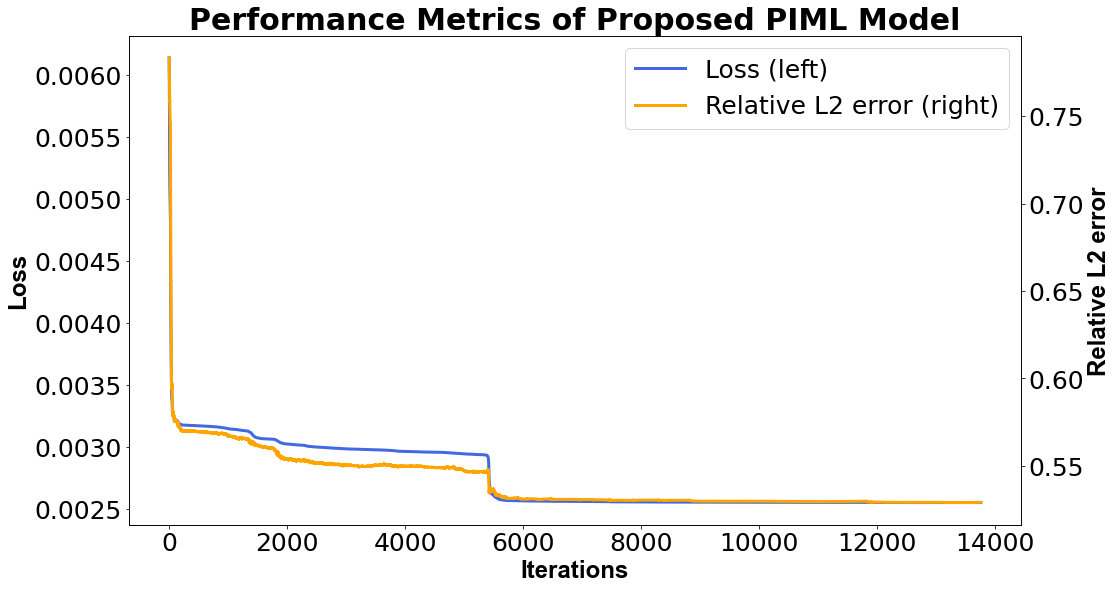

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.021792223072632035
MSE =  0.00310287684677809
RMSE =  0.05570347248402105
L2 relative error = 0.5086029599610105
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

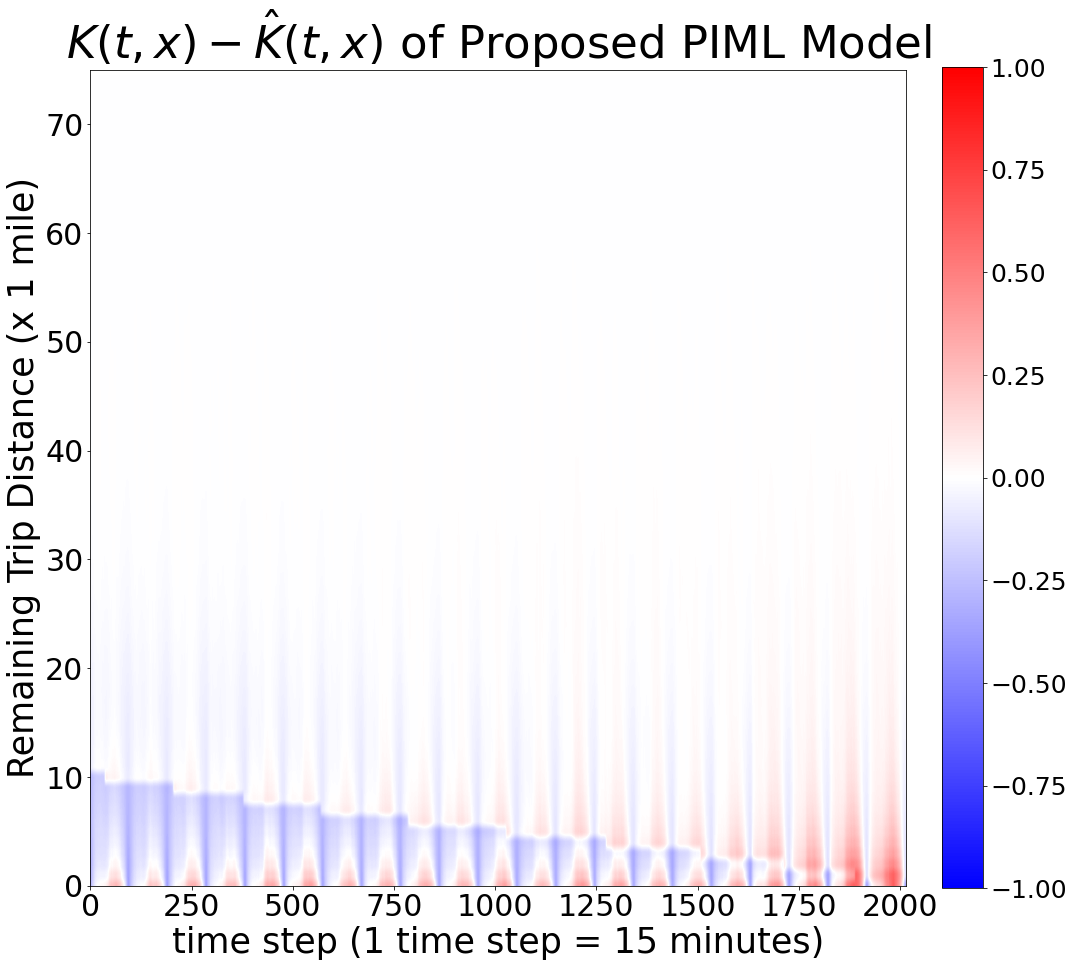

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

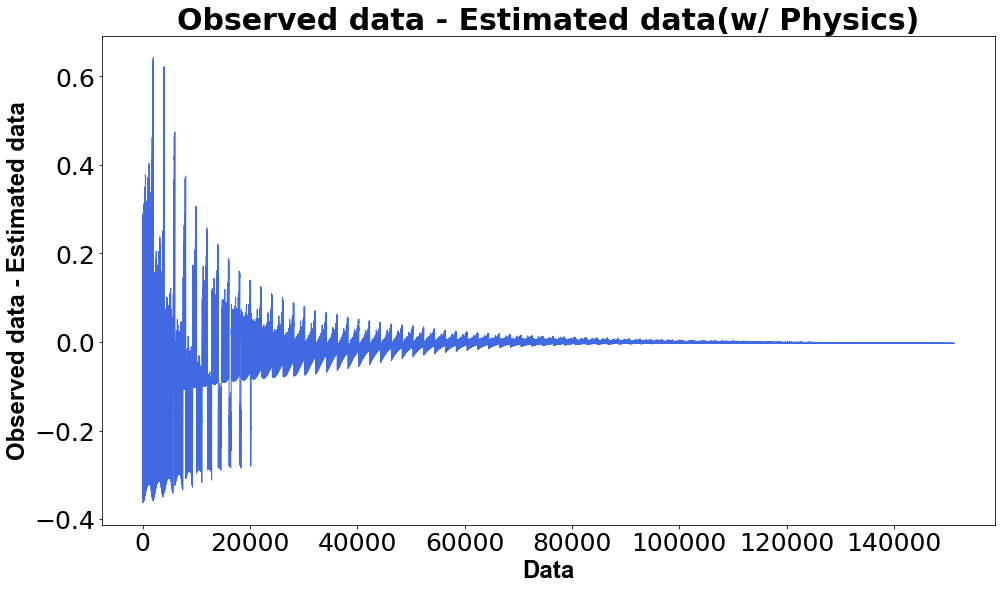

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

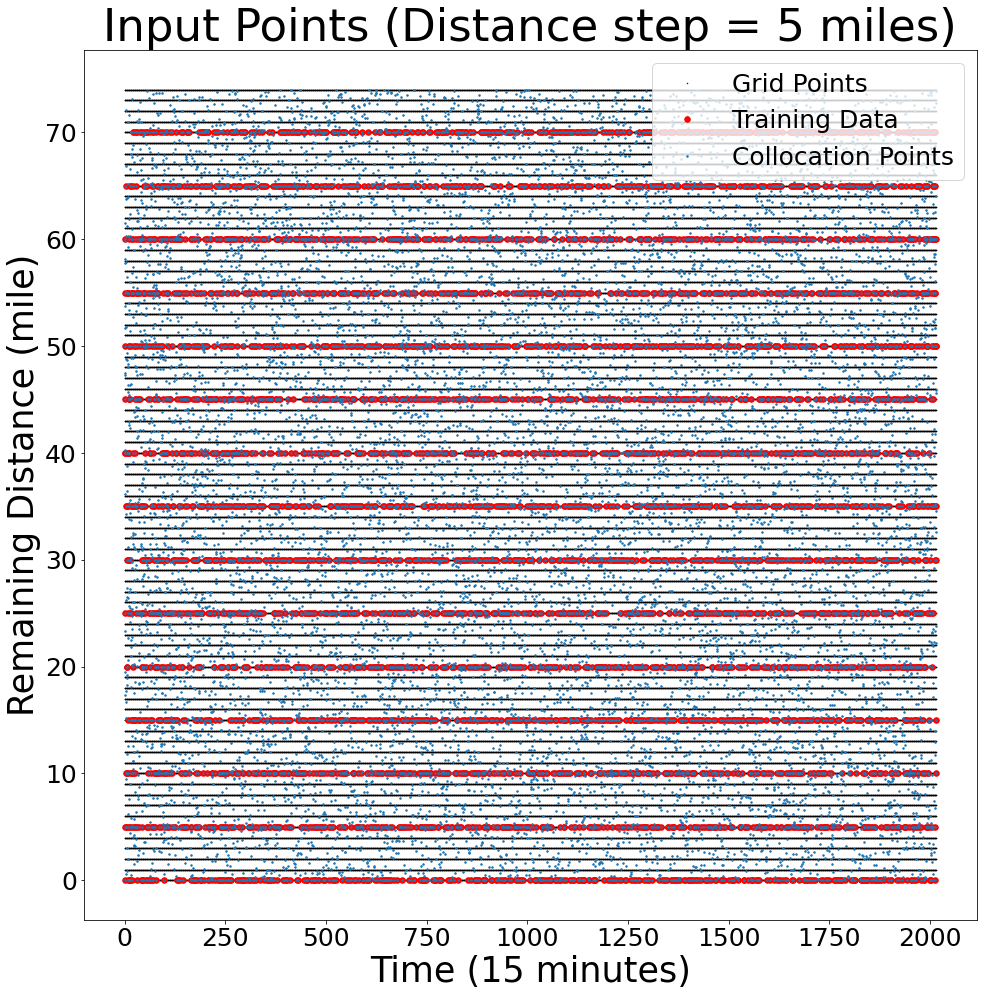

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

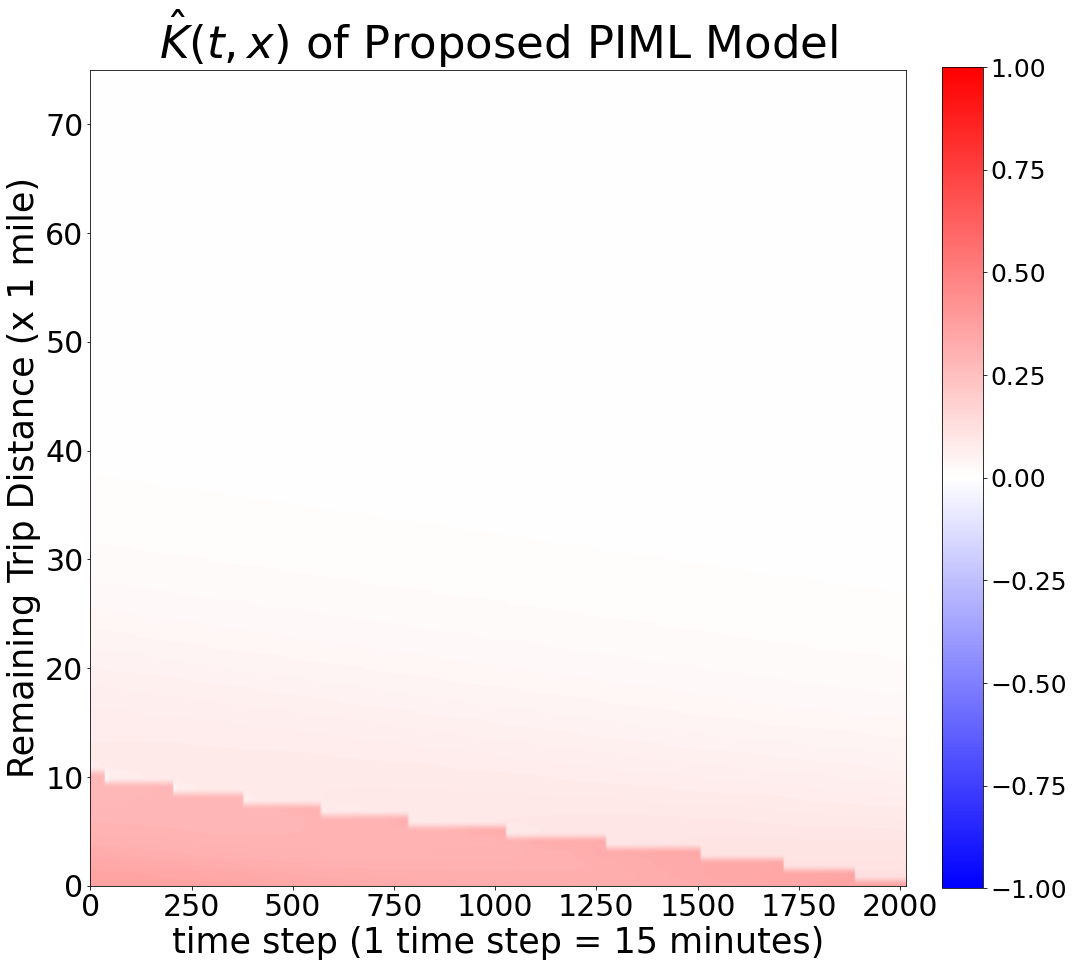

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)